In [1]:
# Setup
import sys
import numpy as np
import tensorflow as tf
import Utils.PokemonUtils as pkmnUtils
from matplotlib import pyplot as plt
from Models import Baseline
import importlib

utils = pkmnUtils.PokemonUtils(rel_loc="")

# Only run if split file has not already been generated
if False:
    utils.loadAllGIFs()
    
utils.localLoadAllGifs("Data/SplitsV2.npz")
x_train, x_val, x_test, y_train, y_val, y_test = utils.getSplits()

USE_GPU = False
if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.
x_train: (6010, 128, 128, 4)
x_val:   (1510, 128, 128, 4)
x_test:  (1880, 128, 128, 4)
y_train: (6010,)
y_val:   (1510,)
y_test:  (1880,)


In [ ]:
# Run on PokemonUtils update
import Utils.PokemonUtils as pkmnUtils
importlib.reload(pkmnUtils)  # update import if PokemonUtils.py changes
utils = pkmnUtils.PokemonUtils(utils=utils)

In [10]:
x_train_m = x_train.astype('float32') 
x_val_m = x_val.astype('float32') 
x_test_m = x_test.astype('float32')
y_train_m = y_train
y_val_m = y_val
y_test_m = y_test

# display these images (range 0-1 necessary for imshow)
x_train_i = (x_train_m) / 255
x_val_i   = (x_val_m)   / 255
x_test_i  = (x_test_m)  / 255

x_mean = np.mean(x_train_m)
x_train_m = (x_train_m - x_mean) / 255
x_val_m   = (x_val_m - x_mean)   / 255
x_test_m  = (x_test_m - x_mean)  / 255

x_train_s = x_train_m[::10]
x_val_s   = x_val_m[::10]
x_test_s  = x_test_m[::10]
y_train_s = y_train_m[::10]
y_val_s   = y_val_m[::10]
y_test_s  = y_test_m[::10]

print("Data normalization:")
print("mean:", x_mean)
print("max: ", np.max(x_train_m))
print("min: ", np.min(x_train_m))
print("Data shapes:")
print("x_train_m:", x_train_m.shape)
print("x_val_m:  ", x_val_m.shape)
print("x_test_m: ", x_test_m.shape)
print("y_train_m:", y_train_m.shape)
print("y_val_m:  ", y_val_m.shape)
print("y_test_m: ", y_test_m.shape)
print("x_train_s:", x_train_s.shape)
print("x_val_s:  ", x_val_s.shape)
print("x_test_s: ", x_test_s.shape)
print("y_train_s:", y_train_s.shape)
print("y_val_s:  ", y_val_s.shape)
print("y_test_s: ", y_test_s.shape)

Data normalization:
mean: 0.1044023
max:  0.9995906
min:  -0.0004094208
Data shapes:
x_train_m: (6010, 128, 128, 4)
x_val_m:   (1510, 128, 128, 4)
x_test_m:  (1880, 128, 128, 4)
y_train_m: (6010,)
y_val_m:   (1510,)
y_test_m:  (1880,)
x_train_s: (601, 128, 128, 4)
x_val_s:   (151, 128, 128, 4)
x_test_s:  (188, 128, 128, 4)
y_train_s: (601,)
y_val_s:   (151,)
y_test_s:  (188,)


Using TensorFlow backend.


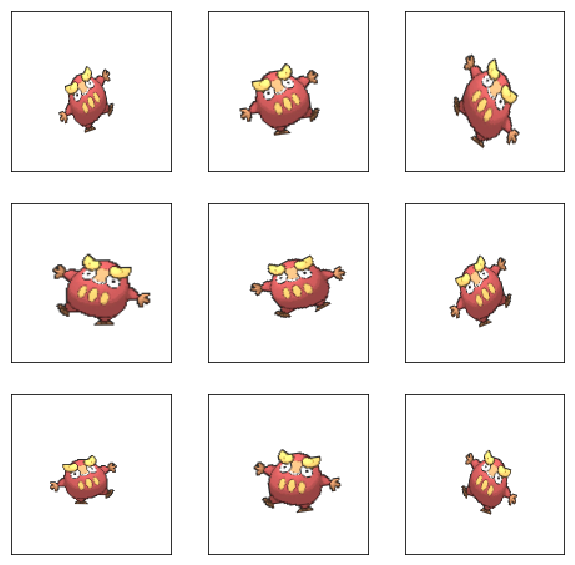

In [4]:
# Functions / objects necessary to train a model
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import skimage.color as color

def oneHot(y, cols=None):
    if (cols < 1):
        cols = np.max(y)
    n = y.shape[0]
    z = np.zeros((n, cols))
    z[np.arange(n), (y-1)] = 1
    return z


data_aug = ImageDataGenerator(
    rotation_range=50,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest"
)

image = x_train_i[0,:,:,:]
image = image.reshape((1,) + image.shape)

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(3,3)

i = 0
for batch in data_aug.flow(image, batch_size=1):
    ax = plt.subplot(gs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(batch[0])
    i += 1
    if i >= 9:
        break

In [63]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras import regularizers
from keras.callbacks import ModelCheckpoint

use_baseline = False
model = None

def getInitialModel(use_baseline, reg=0, drop=0.5):
    if use_baseline:
        model = Sequential([
                Conv2D(32, (5, 5), input_shape=(128,128,4)),
                Activation("relu"),
                MaxPooling2D((2,2)),

                Conv2D(64, (5, 5)),
                Activation("relu"),
                MaxPooling2D((2,2)),

                Flatten(),

                Dense(64),
                Activation("relu"),
                Dense(18),
                Activation("softmax")
            ])
    else:
        print("Model params: drop =", drop, ", reg =", reg)
        model = Sequential([
                Conv2D(32, (5, 5), input_shape=(128,128,4), padding='same', kernel_regularizer=regularizers.l2(reg)),
                Activation("relu"),
                MaxPooling2D((2,2)),

                Conv2D(64, (5, 5), padding='same', kernel_regularizer=regularizers.l2(reg)),
                Activation("relu"),
                MaxPooling2D((2,2)),

                Flatten(),

                Dense(64, kernel_regularizer=regularizers.l2(reg)),
                Activation("relu"),
                Dropout(drop),
                Dense(18, kernel_regularizer=regularizers.l2(reg)),
                Activation("softmax")
            ])
    return model
  
model = getInitialModel(False, reg=.005, drop=.1)

Model params: drop = 0.1 , reg = 0.005


In [64]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [65]:
# Training
filepath = "./Models/neuralmon_model_4.hdf5"
batch_size = 64
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(
    data_aug.flow(x_train_m, oneHot(y_train_m, 18), batch_size=batch_size),
    epochs=30,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=(x_val_m, oneHot(y_val_m, 18)),
)
model.save("./Models/neuralmon_model_4_final.hdf5")

Epoch 1/30
94/94 [==============================] - 198s 2s/step - loss: 3.0969 - acc: 0.1518 - val_loss: 3.0194 - val_acc: 0.1603

Epoch 00001: val_acc improved from -inf to 0.16026, saving model to ./Models/neuralmon_model_4.hdf5
Epoch 2/30
94/94 [==============================] - 187s 2s/step - loss: 2.6847 - acc: 0.2056 - val_loss: 2.8114 - val_acc: 0.1974

Epoch 00002: val_acc improved from 0.16026 to 0.19735, saving model to ./Models/neuralmon_model_4.hdf5
Epoch 3/30
94/94 [==============================] - 187s 2s/step - loss: 2.5272 - acc: 0.2634 - val_loss: 2.7998 - val_acc: 0.2159

Epoch 00003: val_acc improved from 0.19735 to 0.21589, saving model to ./Models/neuralmon_model_4.hdf5
Epoch 4/30
94/94 [==============================] - 188s 2s/step - loss: 2.4409 - acc: 0.2998 - val_loss: 2.7721 - val_acc: 0.2245

Epoch 00004: val_acc improved from 0.21589 to 0.22450, saving model to ./Models/neuralmon_model_4.hdf5
Epoch 5/30
94/94 [==============================] - 187s 2s/ste

In [154]:
history2 = model.fit_generator(
    data_aug.flow(x_train_m, oneHot(y_train_m, 18), batch_size=batch_size),
    epochs=20,
    verbose=1,
    validation_data=(x_val_m, oneHot(y_val_m, 18)),
    steps_per_epoch=x_train_m.shape[0] // batch_size * aug_factor,
    initial_epoch = 15
)
# model.save("./Models/neuralmon_model_2.2.hdf5")

Epoch 16/20
  2/930 [..............................] - ETA: 28:05 - loss: 0.6128 - acc: 0.7734

KeyboardInterrupt: 

In [78]:
from keras.models import load_model
# model.load_weights("./Models/neuralmon_model_2.hdf5")
model = load_model("./Models/neuralmon_model_4.hdf5")

In [66]:
h = {}
h = history.history
# for k in history.history.keys():
#     h[k] = history.history[k] + history2.history[k]

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


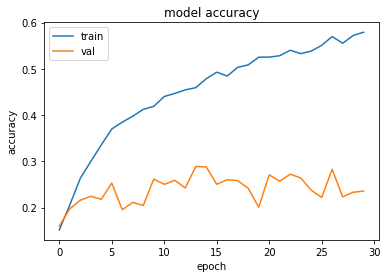

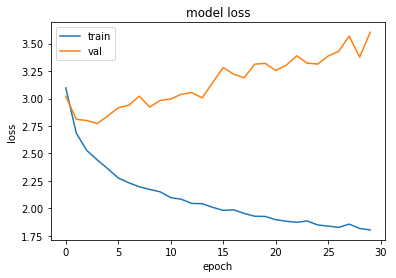

In [67]:
# list all data in history
print(h.keys())

# summarize history for accuracy
plt.plot(h['acc'])
plt.plot(h['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(h['loss'])
plt.plot(h['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [81]:
pred_train_m = model.predict(x_train_m)
print('Done!')
pred_val_m = model.predict(x_val_m)
print('Done!')
pred_test_m = model.predict(x_test_m)
print('Done')

Done


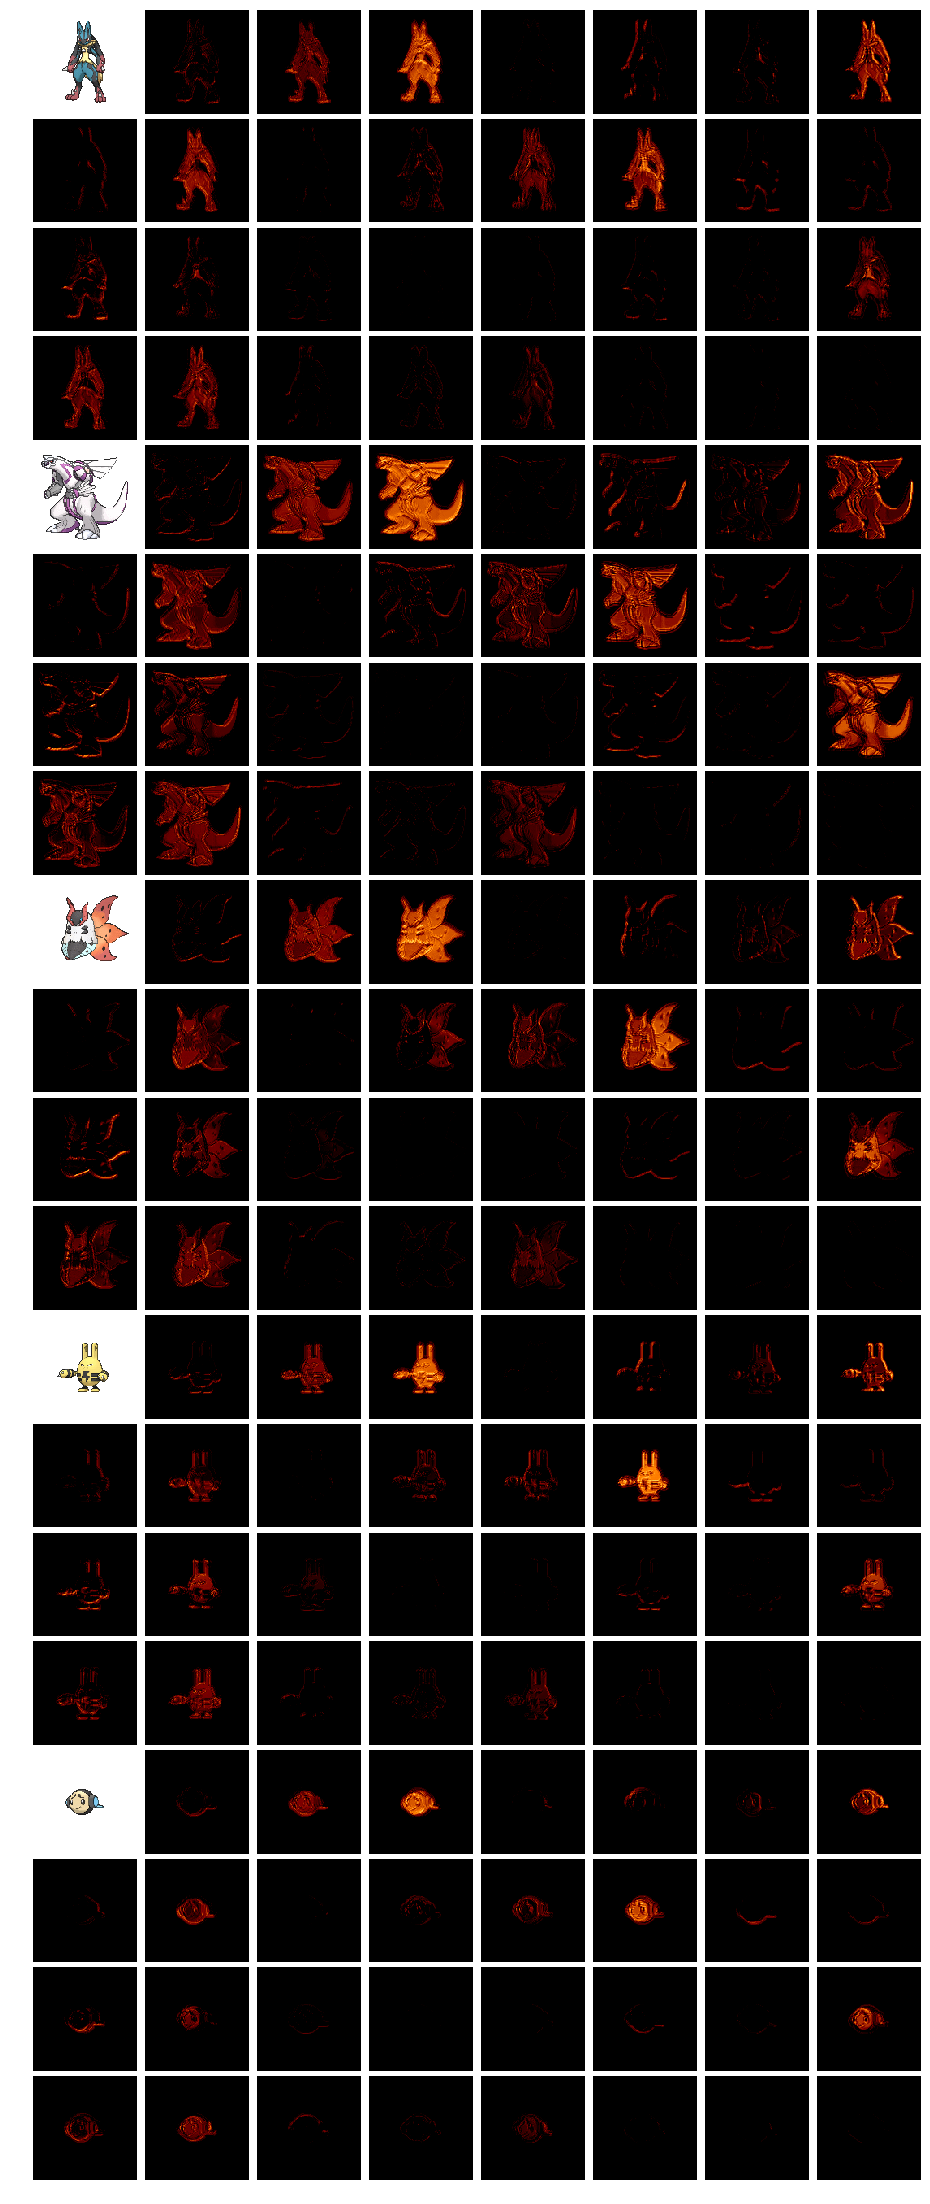

In [83]:
# we build a new model with the activations of the old model
# this model is truncated after the first layer
model_trunc = Sequential([
    Conv2D(32, (5, 5), input_shape=(128,128,4), padding='same', kernel_regularizer=regularizers.l2(reg)),
    Activation("relu"),
])

start = 0
num = 50
step = 10

plt.figure(figsize=(16,8*num))
gs = gridspec.GridSpec(num*4,8)
gs.update(wspace=0.025, hspace=0.05)

idx = 0
for j in range(start, start+num, step):
    activations = model_trunc.predict(x_val_m[j].reshape(1,128,128,4))
    for i in range(0,32):        
        layer_filter = activations.reshape([128,128,32])[:,:,i]
        ax = plt.subplot(gs[32*idx+i])
        plt.axis("off")  
        if i == 0:
            plt.imshow(x_val_i[j])
        else:
            plt.imshow(layer_filter,cmap="afmhot",vmin=0, vmax=1)
    idx += 1

In [73]:
# Get secondary typing 
y_train_2, y_val_2, y_test_2 = utils.getSecondaryTypeLabels()

y_train_2: (6010,)
y_val_2:   (1510,)
y_test_2:  (1880,)


In [101]:
# Averages scores across frames of pokemon's animation
def customPredict(scores, y, y2=None, frames=10):
    # Averaging
    N, T = scores.shape
    scores_reshaped = scores.reshape((N//10, 10, T))
    avg_scores = np.mean(scores_reshaped, axis=1)
    
    # Primary accuracy
    predictions = np.argmax(avg_scores, axis=1)
    matches = predictions == y-1  # y is 1-indexed
    acc1 = np.sum(matches)/len(matches)
    
    acc2 = None
    if not y2 is None:
        matches2 = predictions == y2-1
        acc2 = np.sum(matches + matches2)/len(matches)  # + acts as an or operator
    
    # Dual accuracy
    return (acc1, acc2, avg_scores)
    

train_acc, train_acc_2, train_avg_scores = customPredict(pred_train_m, y_train_m[::10], y2=y_train_2[::10])
val_acc, val_acc_2, val_avg_scores = customPredict(pred_val_m, y_val_m[::10], y2=y_val_2[::10])
test_acc, test_acc_2, test_avg_scores = customPredict(pred_test_m, y_test_m[::10], y2=y_test_2[::10])
print("Train accuracy primary:       ", train_acc)
print("Train accuracy secondary:     ", train_acc_2)
print("Validation accuracy primary:  ", val_acc)
print("Validation accuracy secondary:", val_acc_2)
print("Test accuracy primary:        ", test_acc)
print("Test accuracy secondary:      ", test_acc_2)

Train accuracy primary:        0.6039933444259568
Train accuracy secondary:      0.6239600665557404
Validation accuracy primary:   0.31125827814569534
Validation accuracy secondary: 0.33112582781456956
Test accuracy primary:         0.30851063829787234
Test accuracy secondary:       0.34574468085106386


In [86]:
import Utils.PokemonPlot as pp
importlib.reload(pp)  # update import for changes

<module 'Utils.PokemonPlot' from '/home/zack/pokemon-learning/Utils/PokemonPlot.py'>

Train predictions


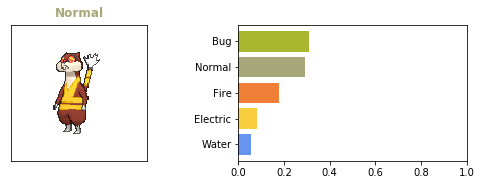

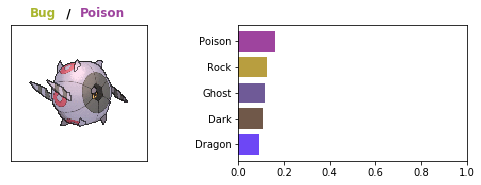

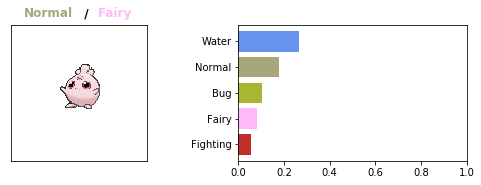

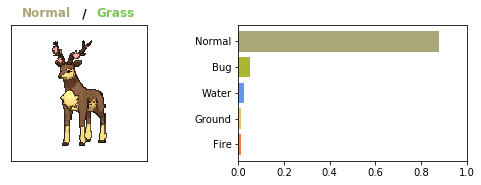

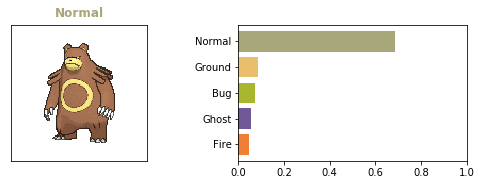

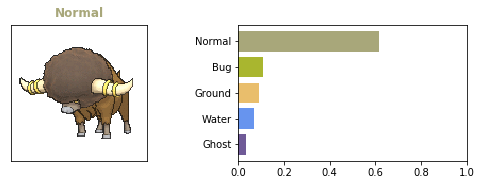

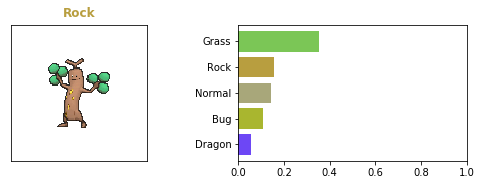

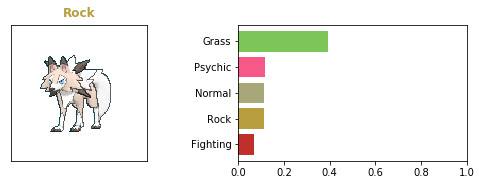

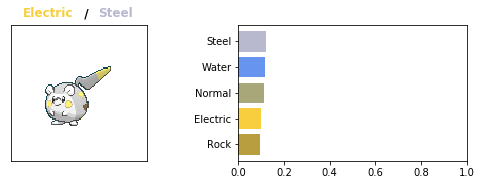

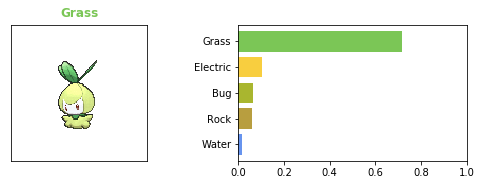

In [92]:
start = 100  # start index
num = 10    # number of images to display
step = 10  # number of frames / pokemon animation

print("Train predictions")
pp.plotPredictions(x_train_i[start*step:(start+num)*step:step],
                   y_train_m[start*step:(start+num)*step:step],
                   train_avg_scores[start:start+num:1], k=5, y2=y_train_2[start*step:(start+num)*step:step])

Validation predictions


/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


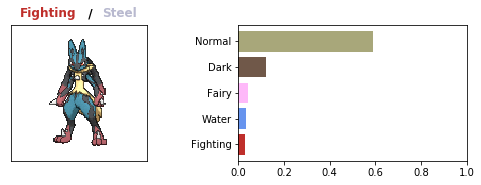

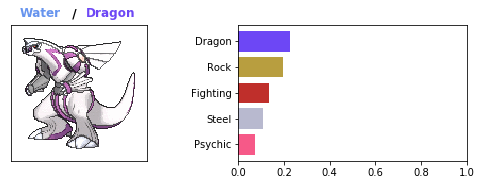

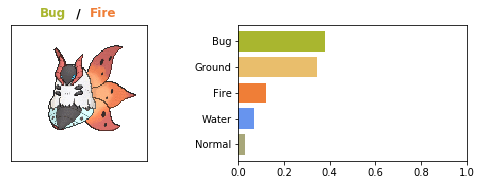

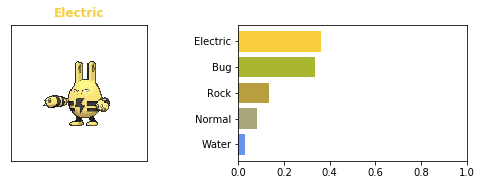

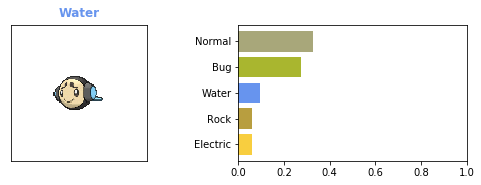

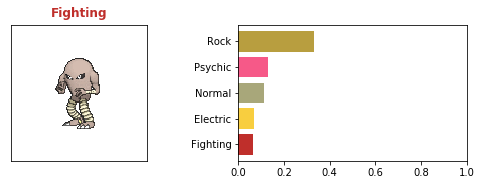

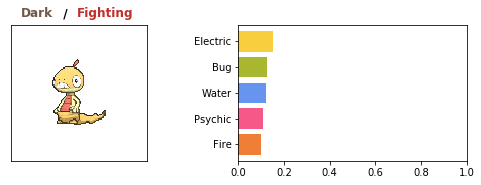

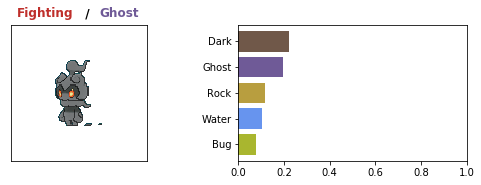

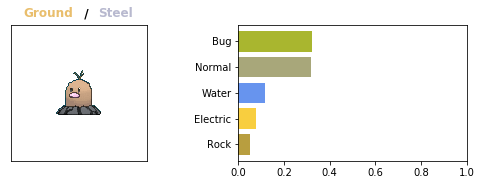

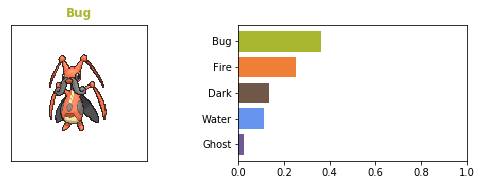

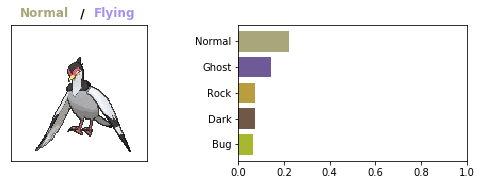

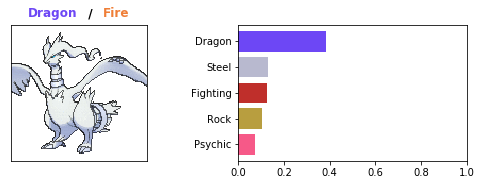

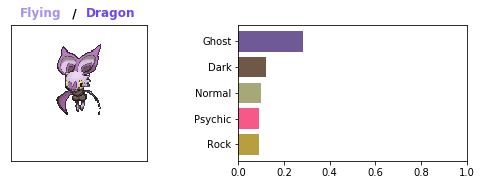

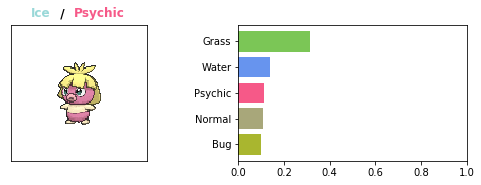

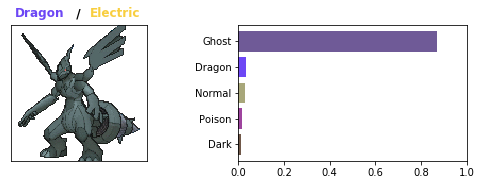

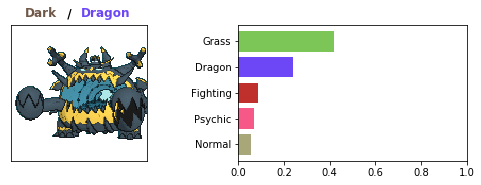

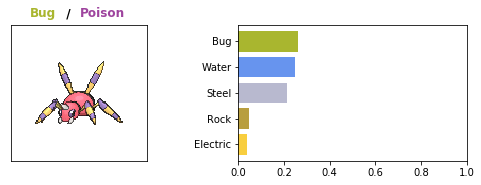

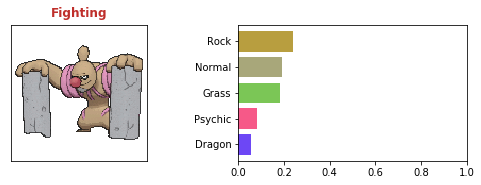

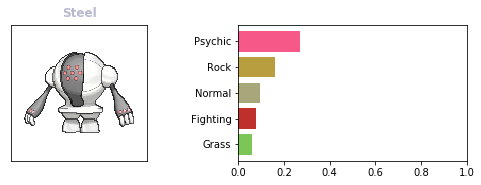

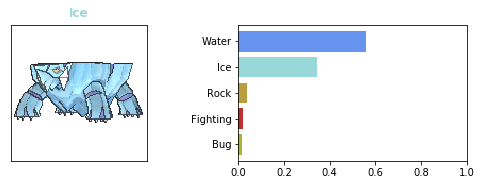

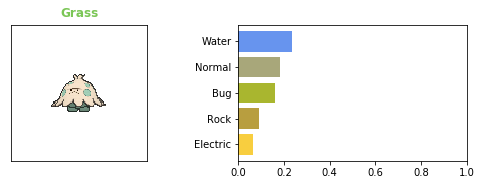

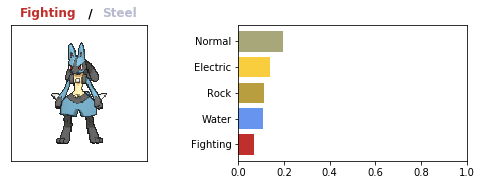

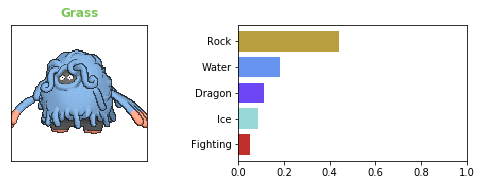

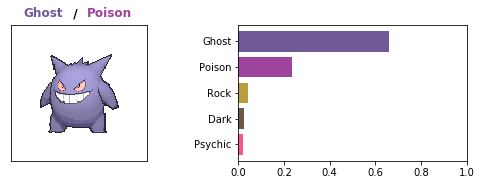

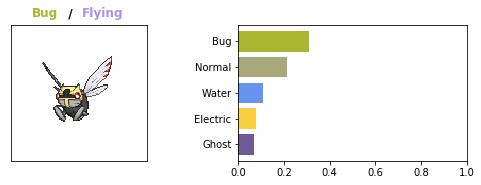

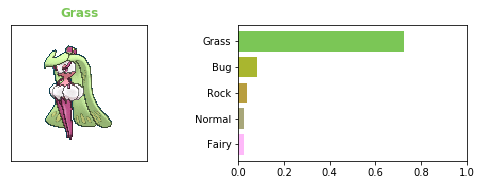

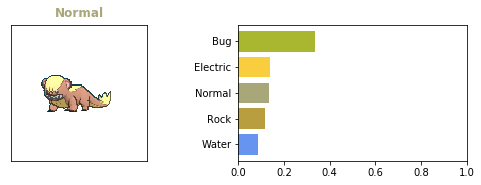

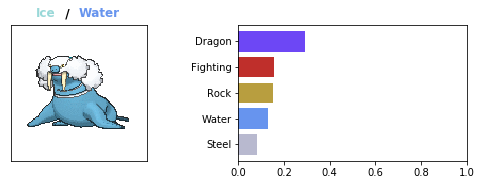

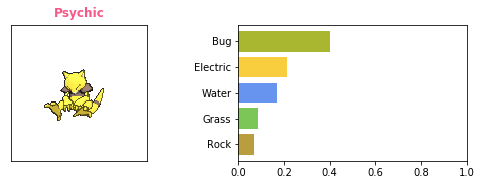

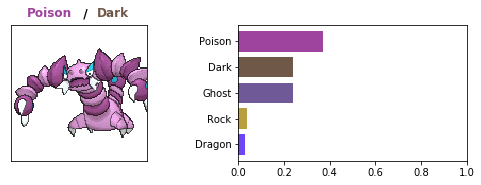

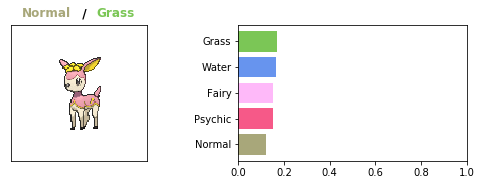

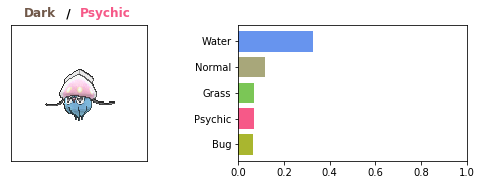

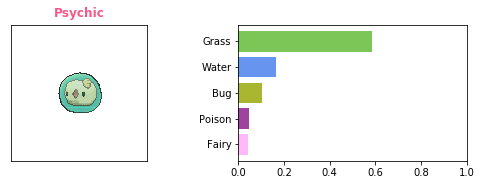

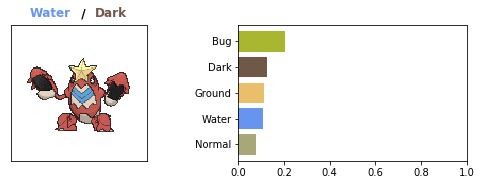

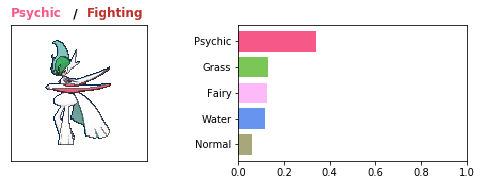

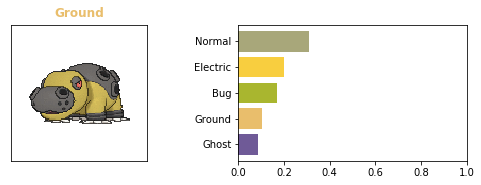

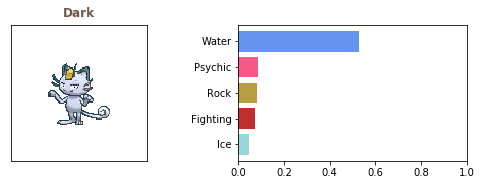

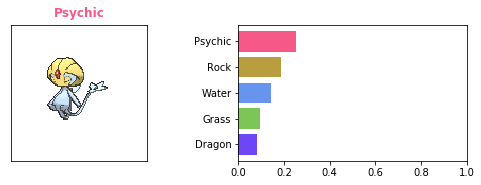

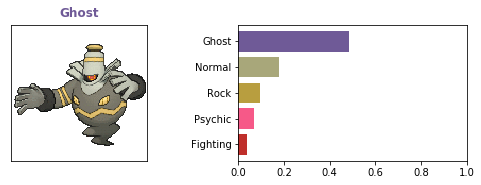

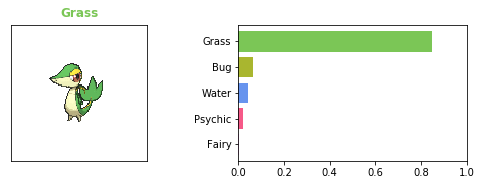

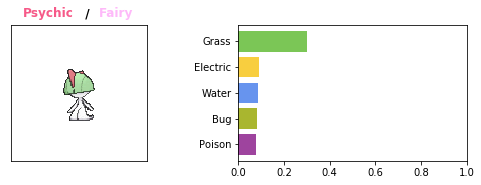

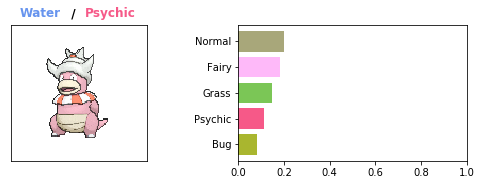

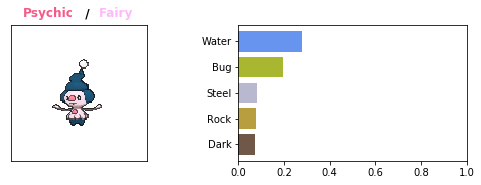

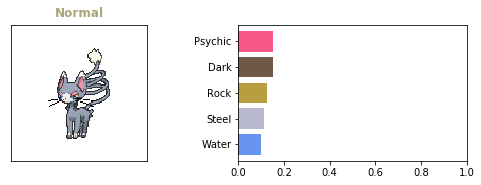

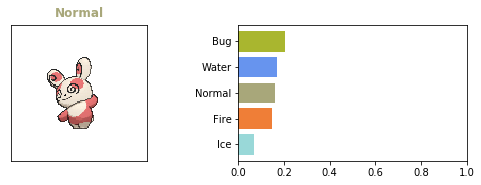

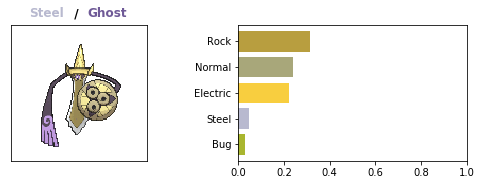

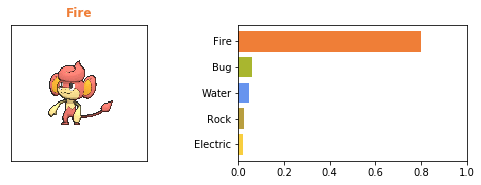

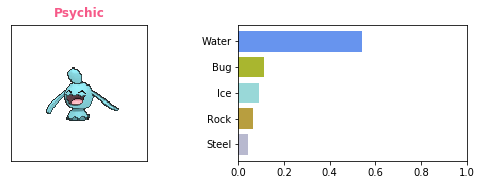

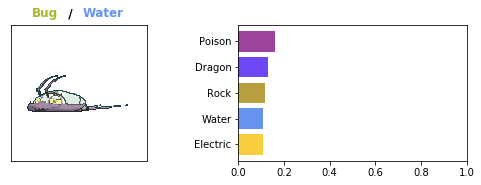

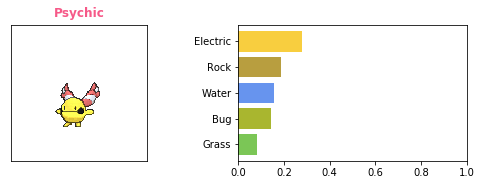

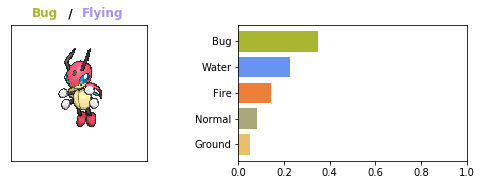

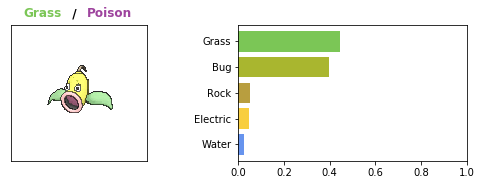

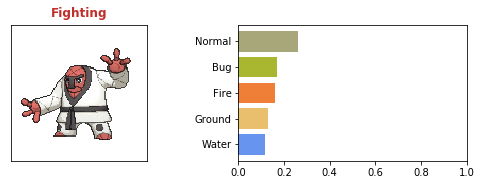

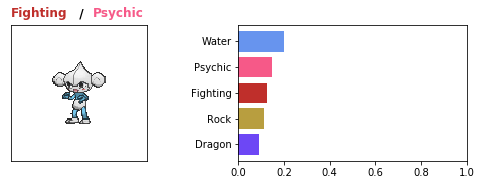

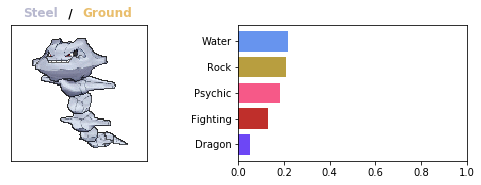

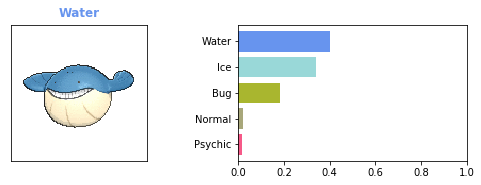

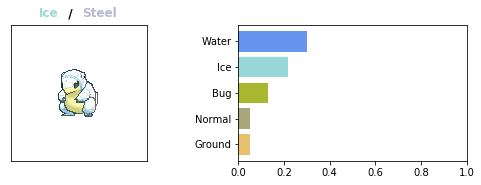

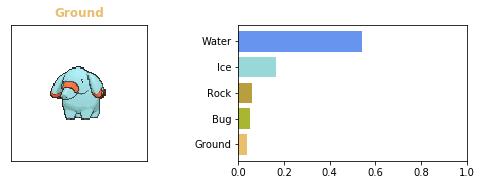

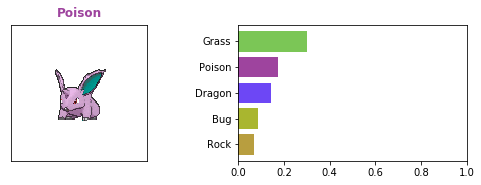

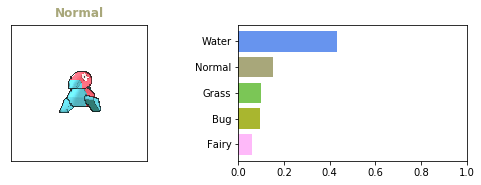

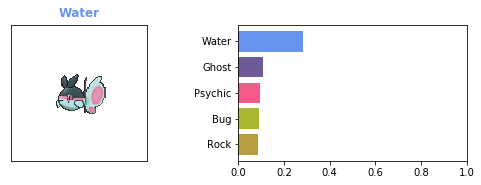

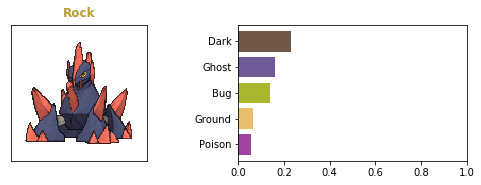

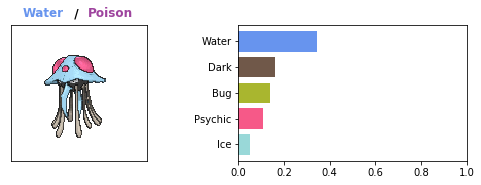

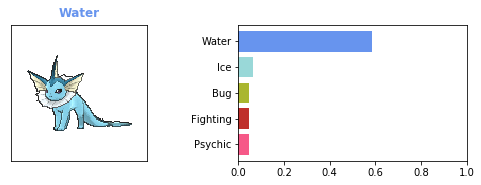

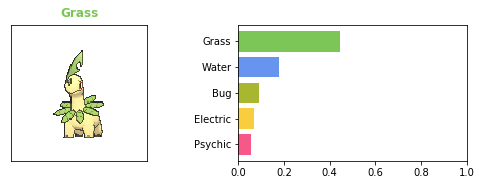

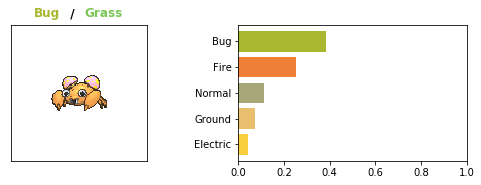

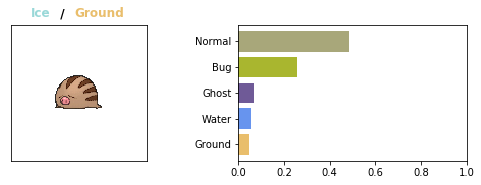

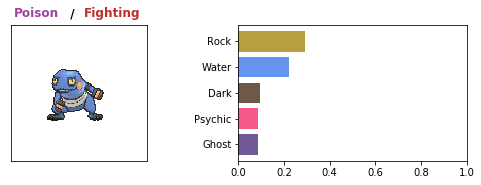

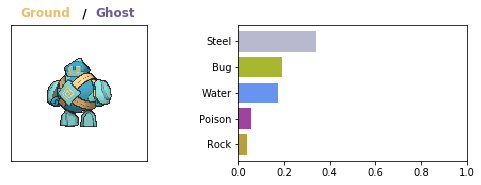

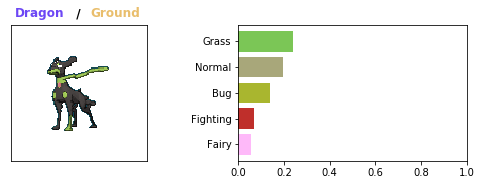

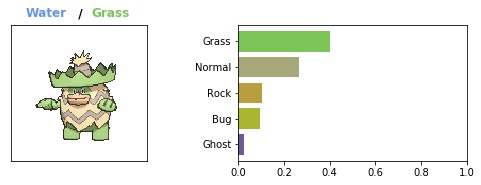

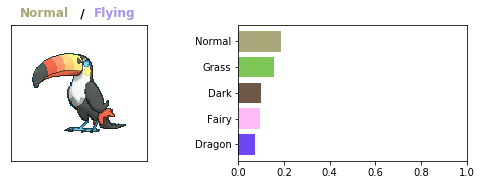

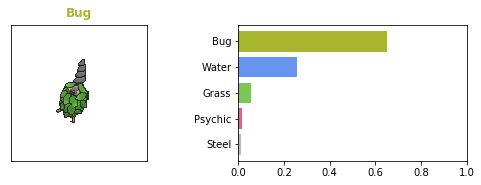

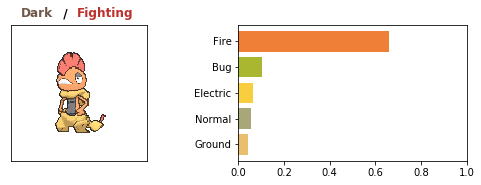

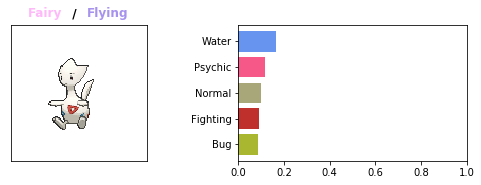

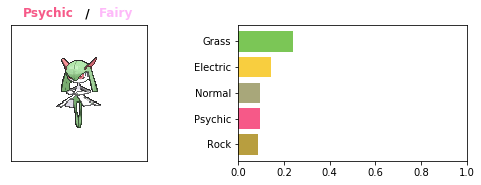

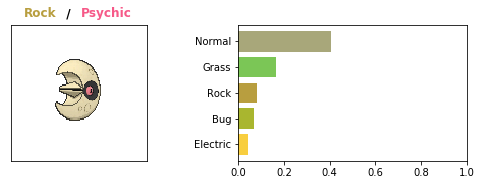

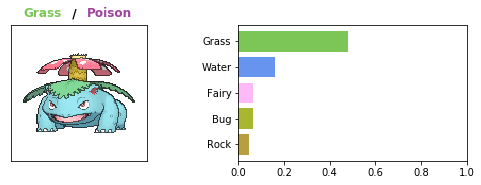

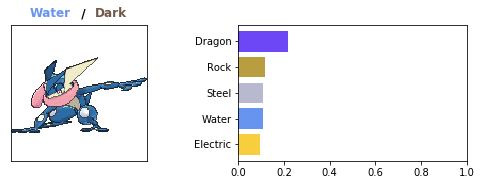

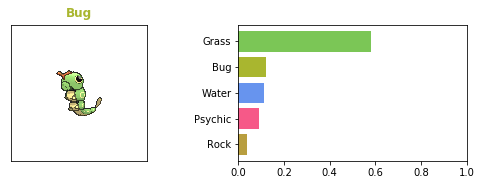

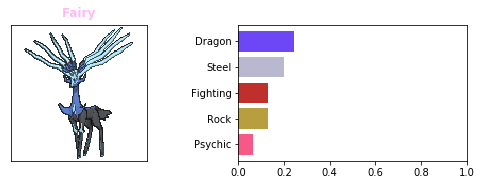

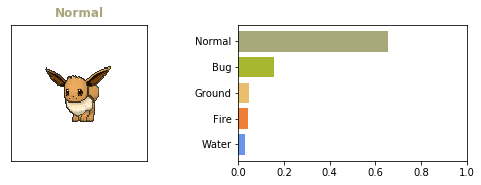

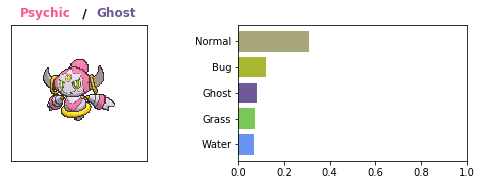

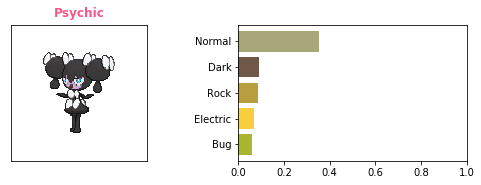

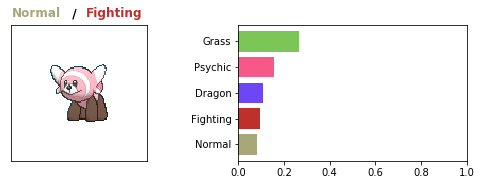

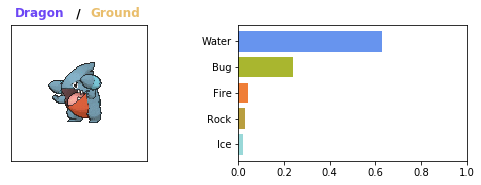

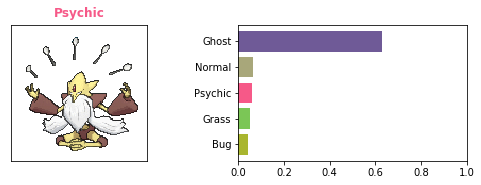

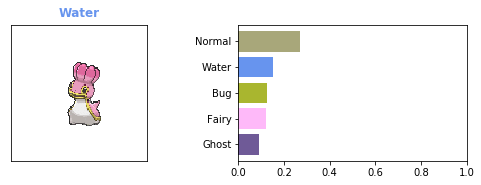

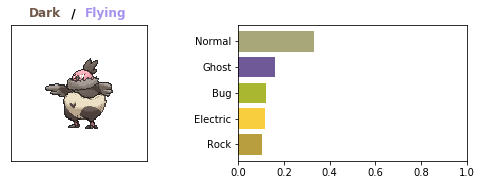

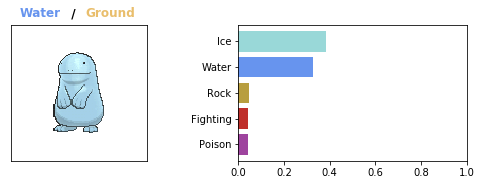

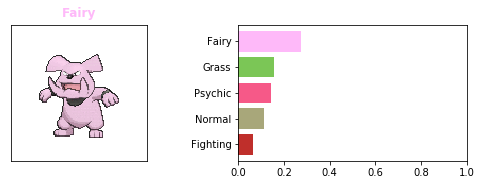

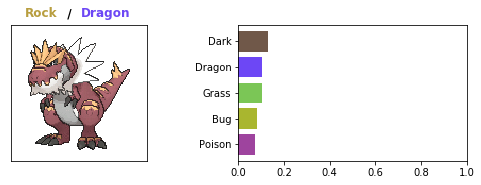

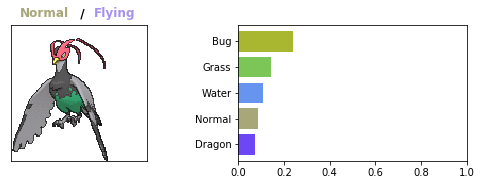

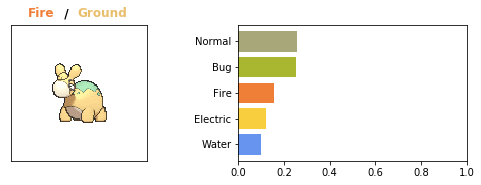

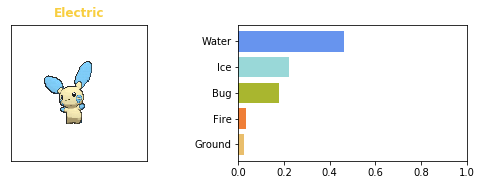

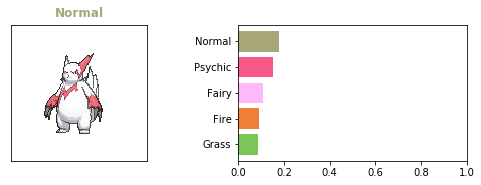

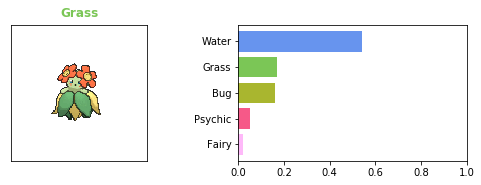

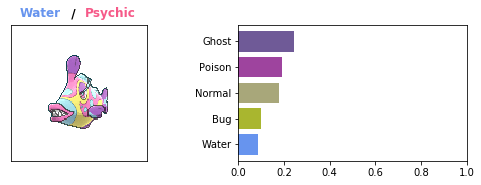

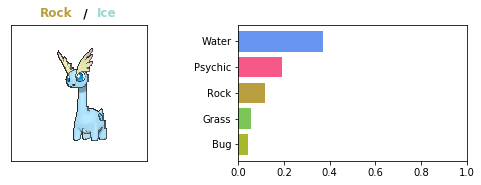

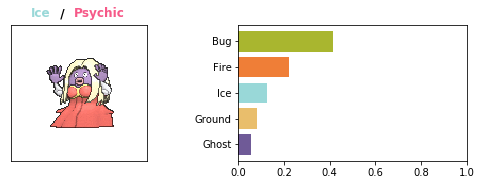

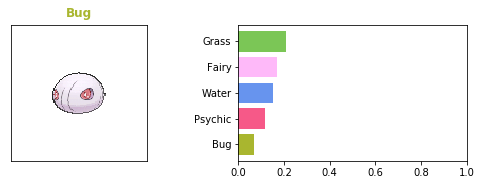

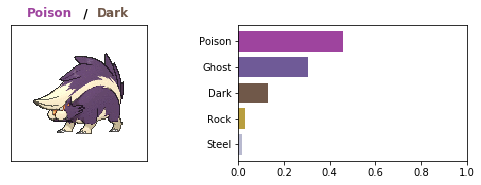

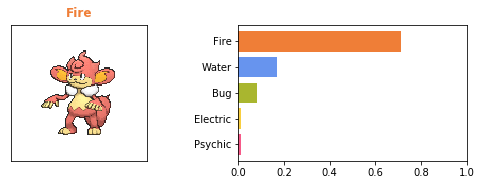

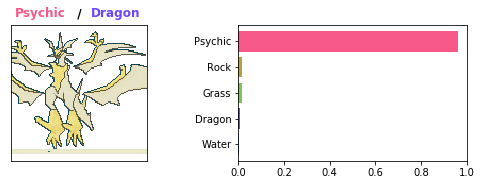

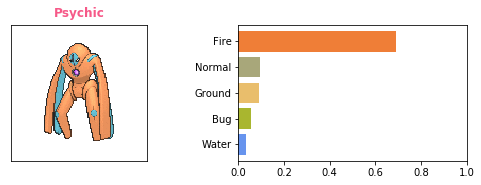

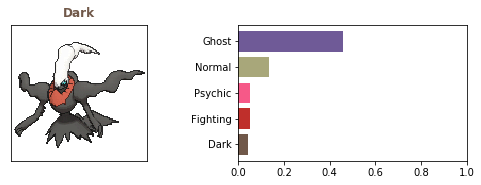

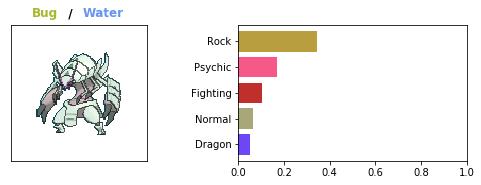

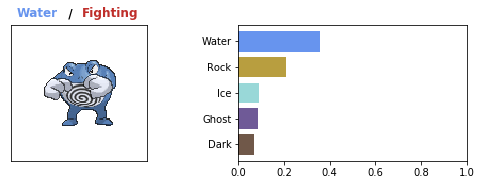

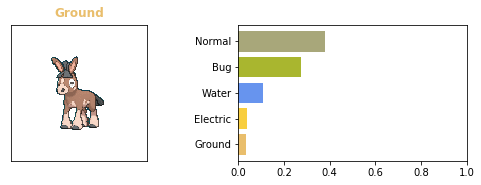

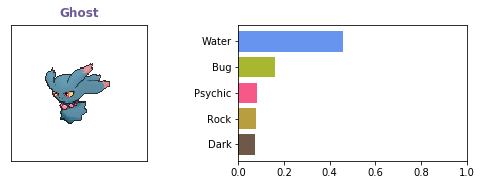

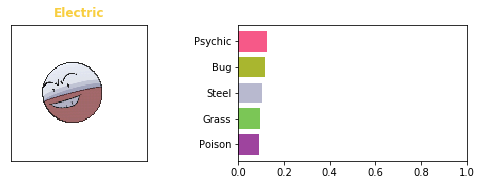

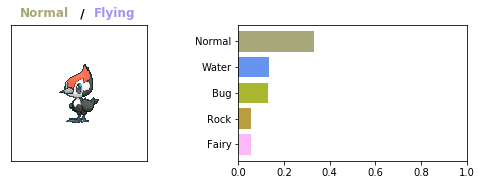

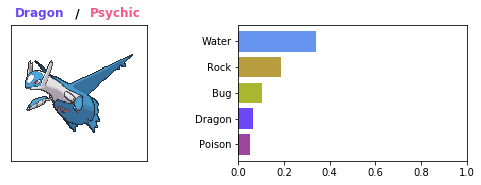

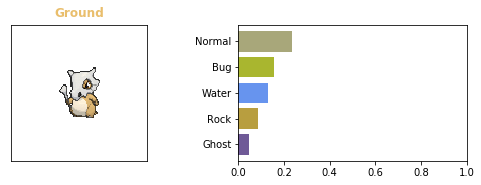

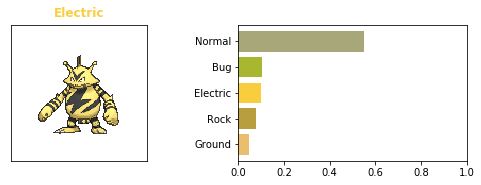

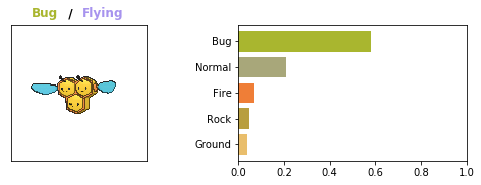

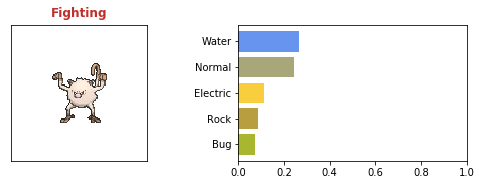

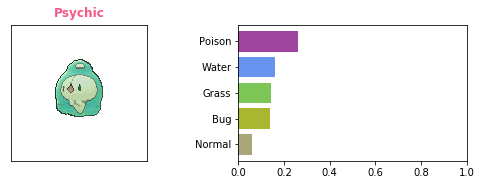

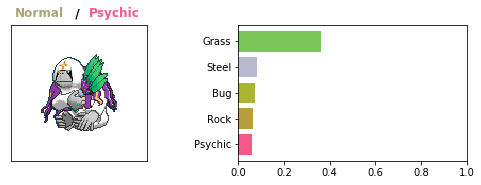

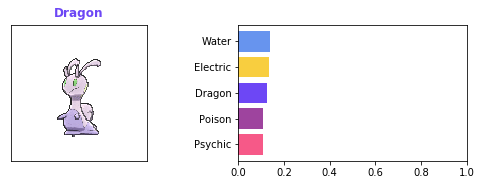

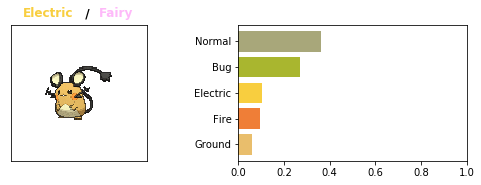

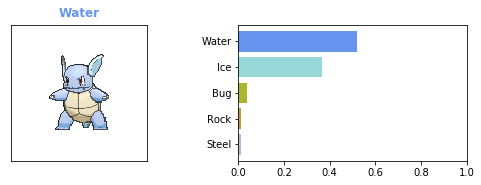

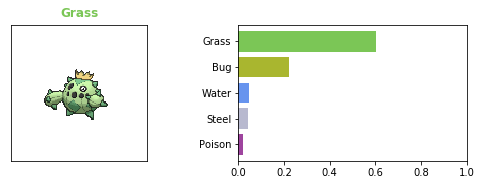

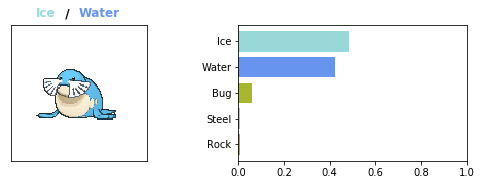

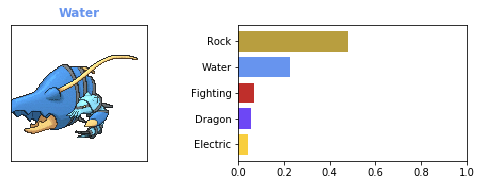

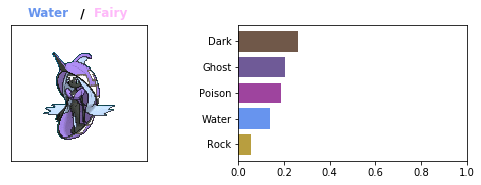

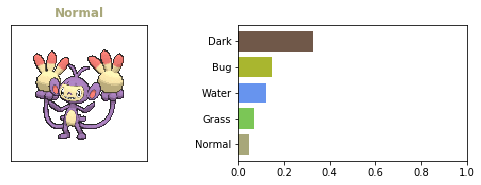

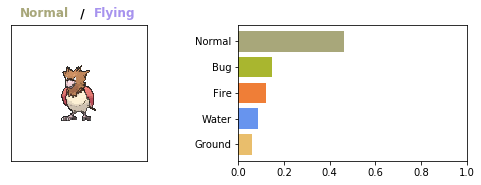

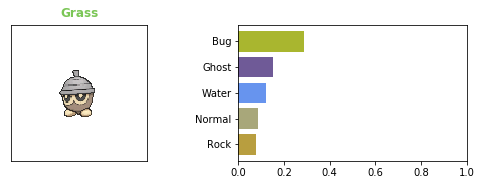

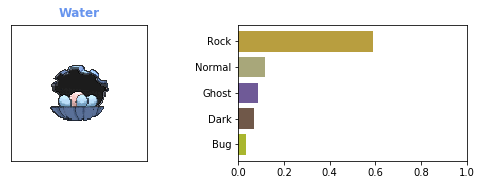

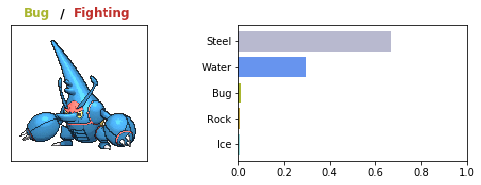

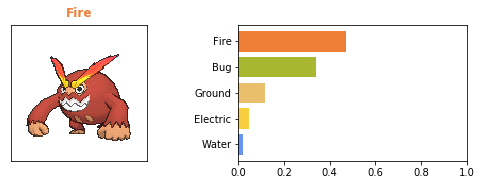

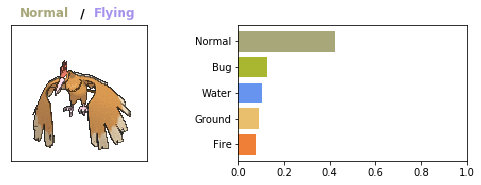

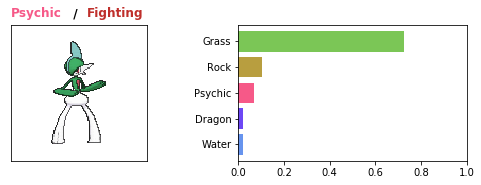

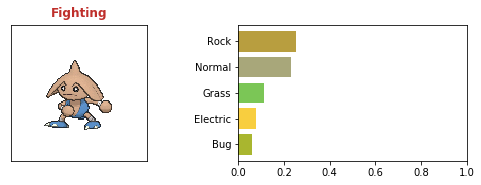

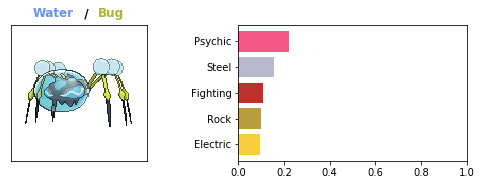

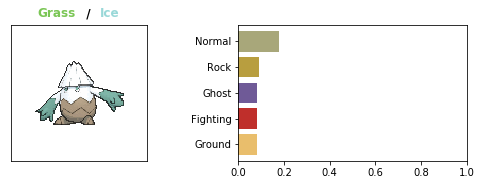

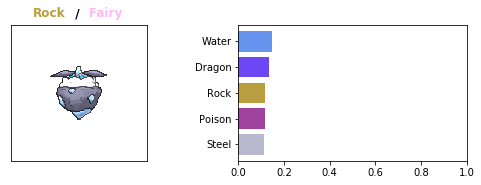

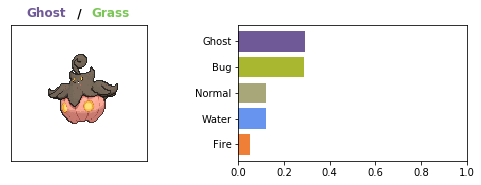

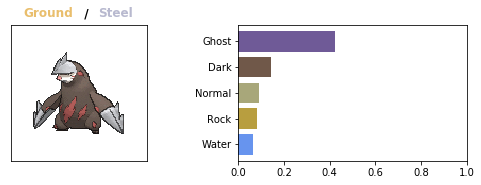

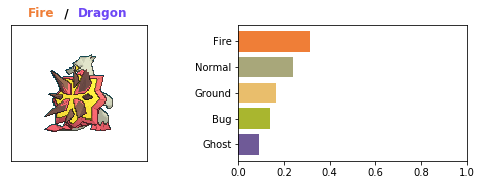

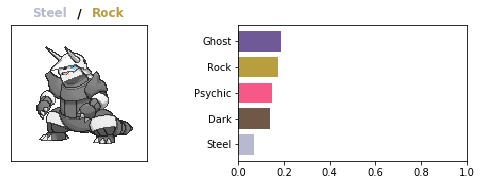

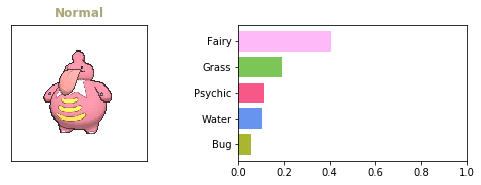

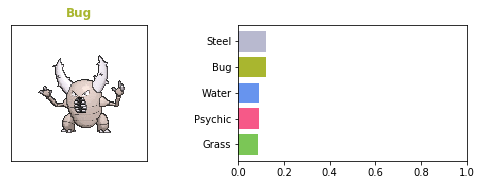

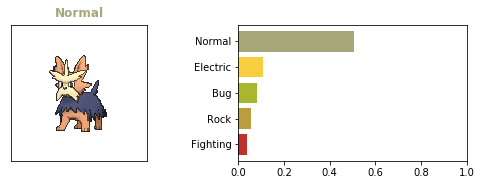

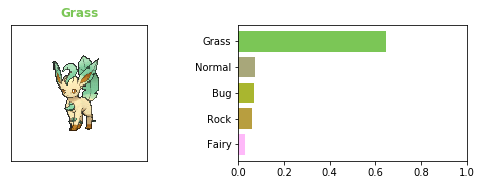

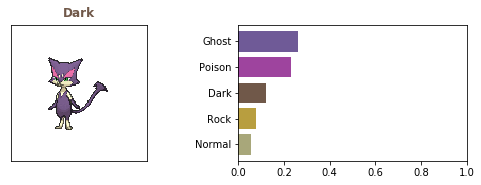

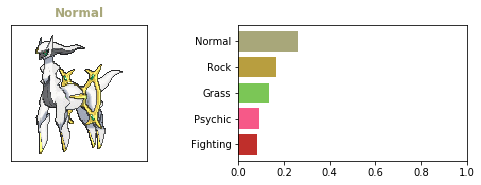

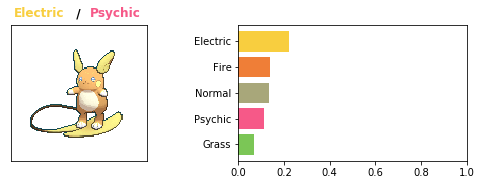

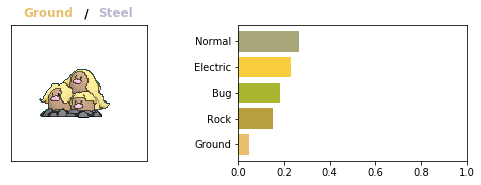

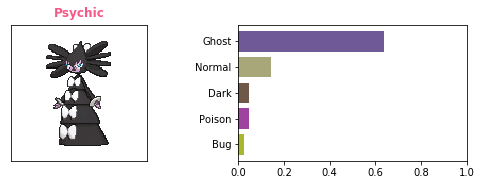

In [93]:
start = 0  # start index
num = 200    # number of images to display
step = 10  # number of frames / pokemon animation

print("Validation predictions")
pp.plotPredictions(x_val_i[start*step:(start+num)*step:step],
                   y_val_m[start*step:(start+num)*step:step],
                   val_avg_scores[start:start+num:1], k=5, y2=y_val_2[start*step:(start+num)*step:step])

Test predictions


/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


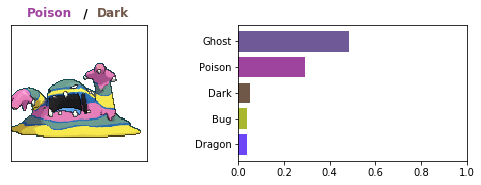

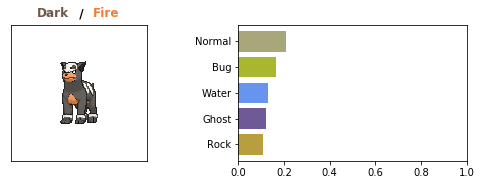

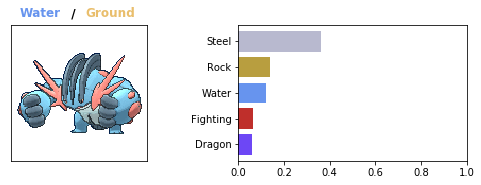

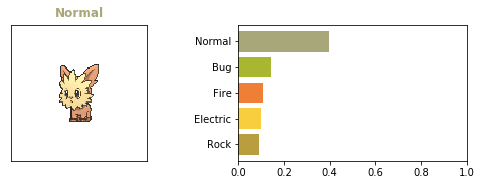

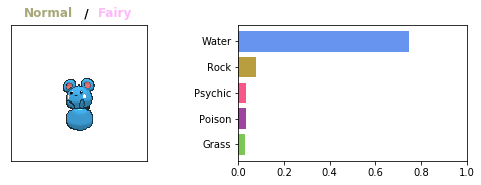

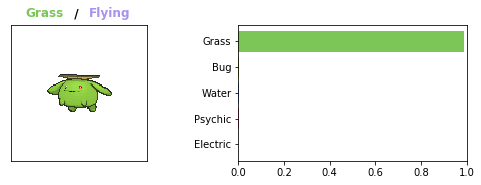

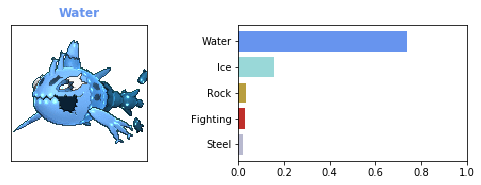

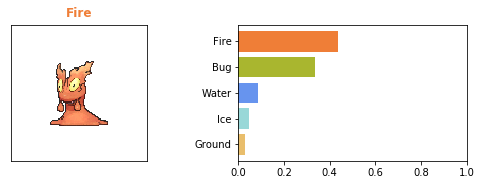

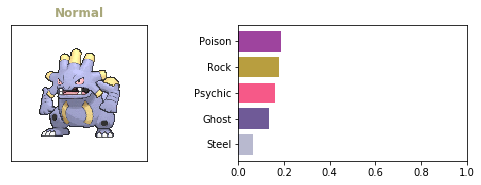

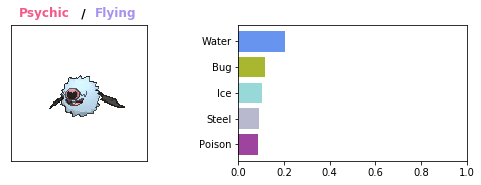

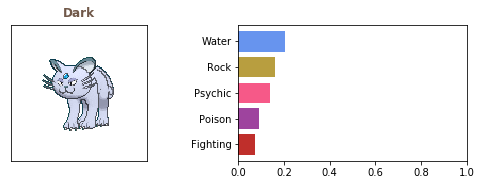

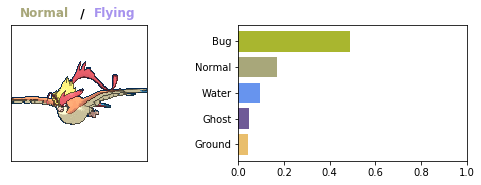

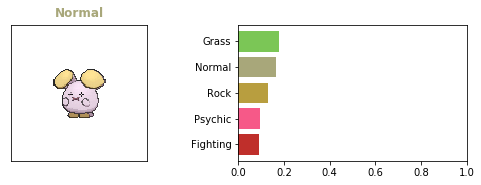

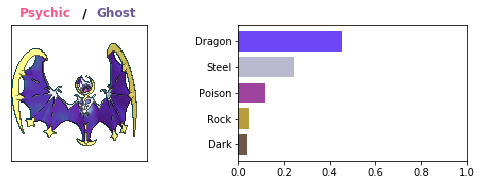

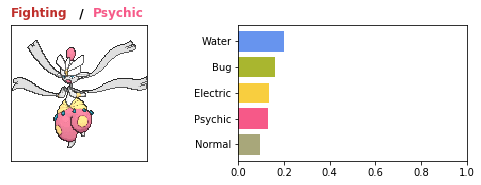

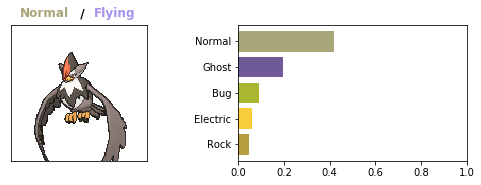

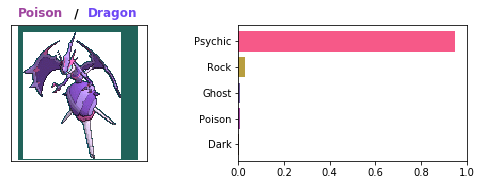

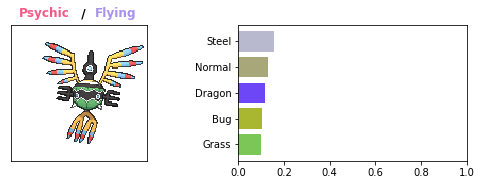

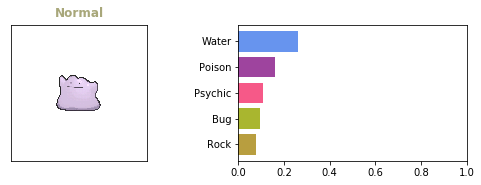

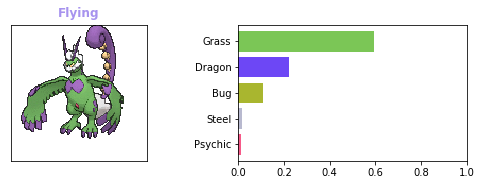

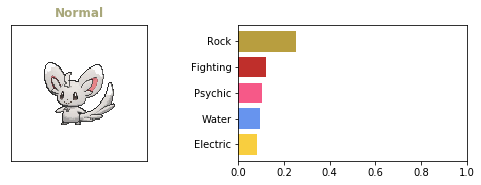

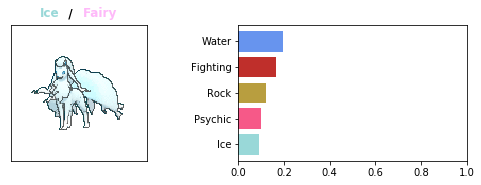

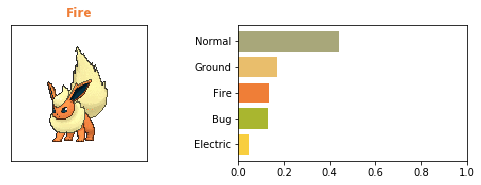

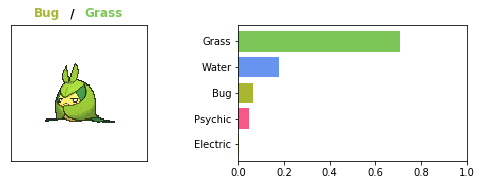

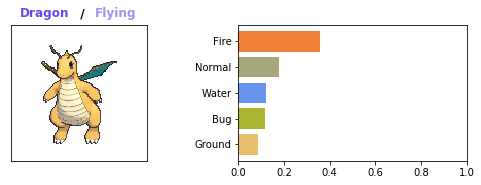

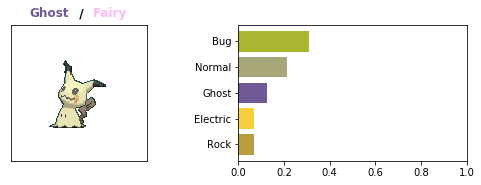

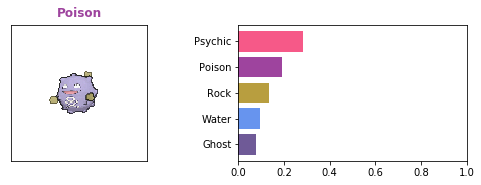

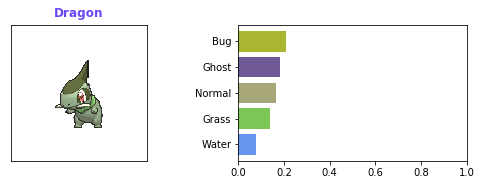

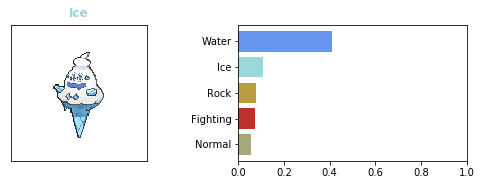

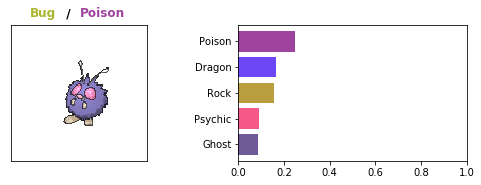

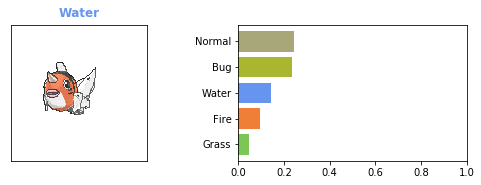

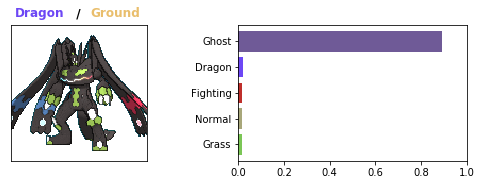

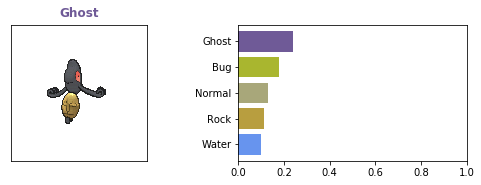

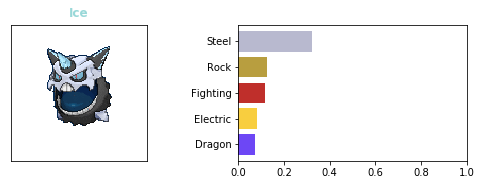

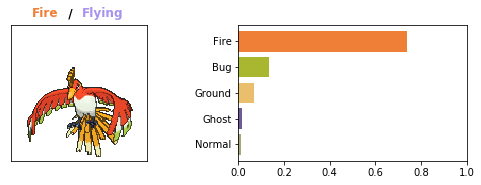

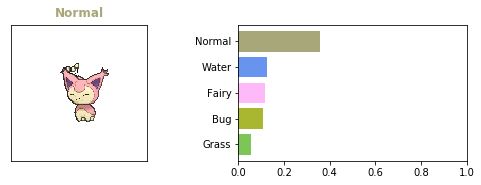

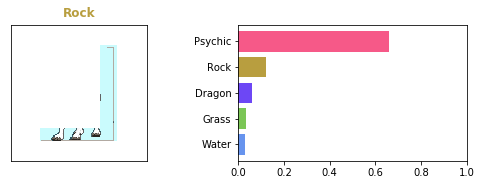

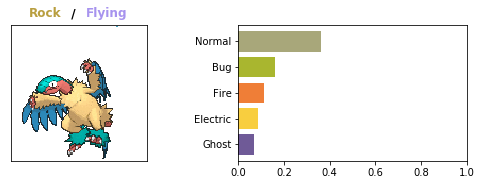

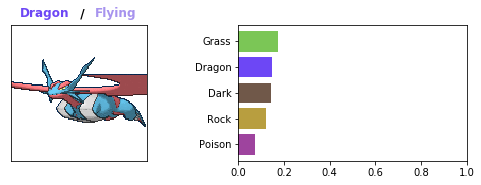

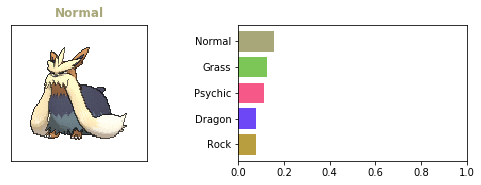

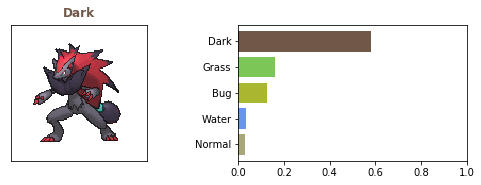

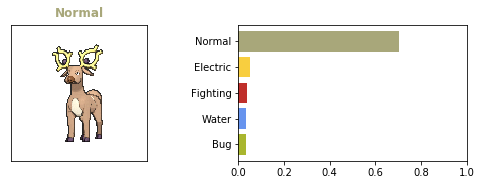

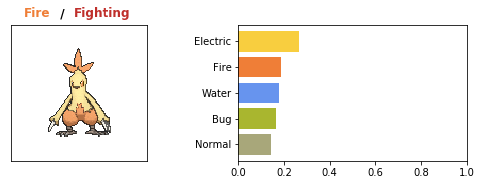

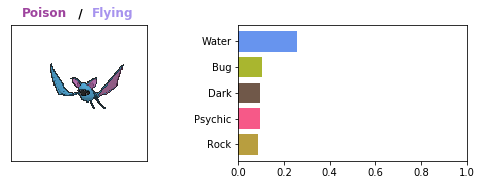

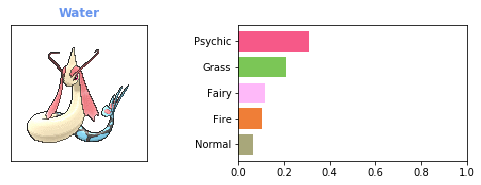

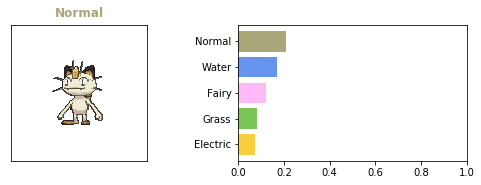

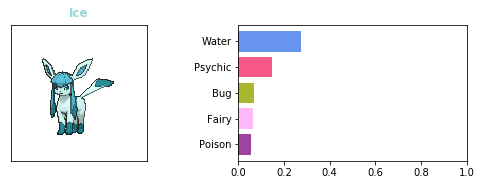

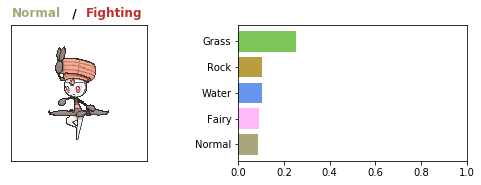

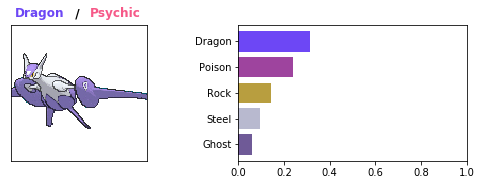

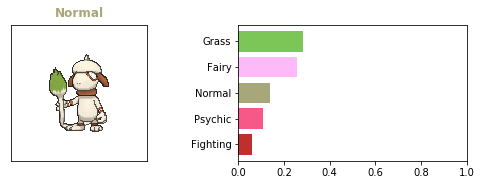

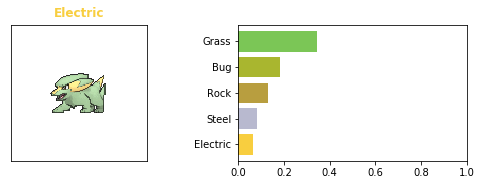

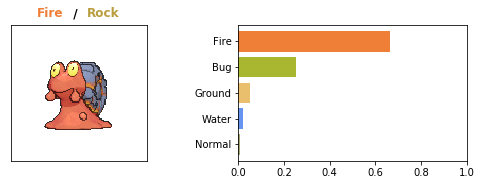

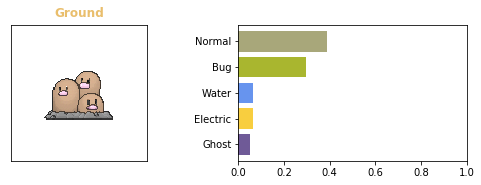

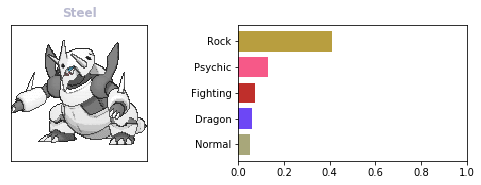

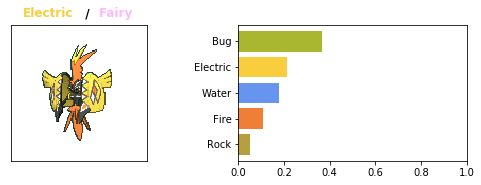

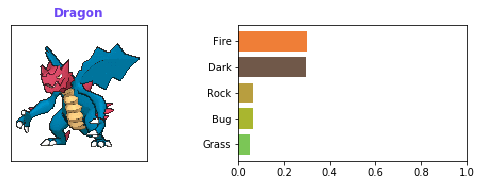

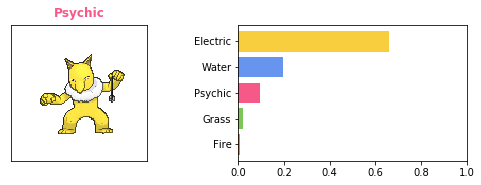

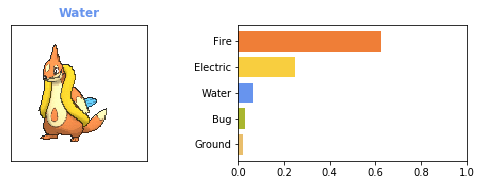

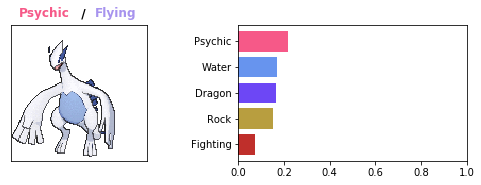

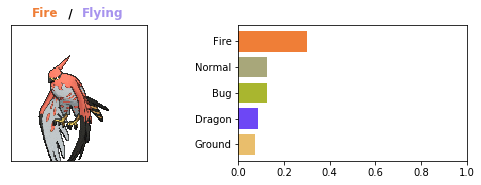

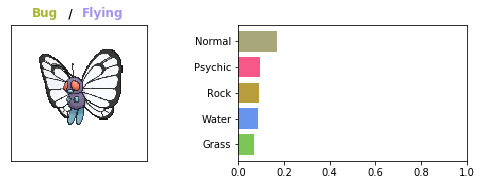

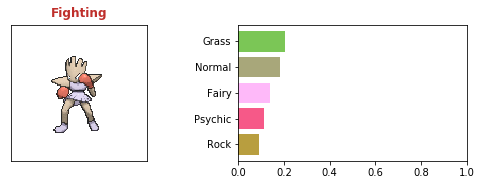

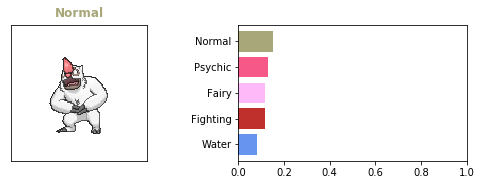

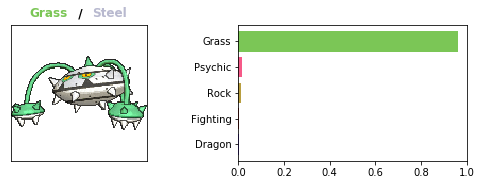

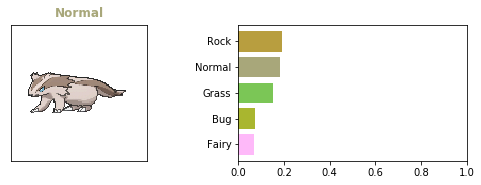

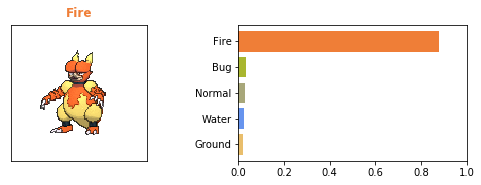

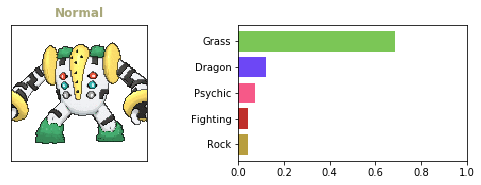

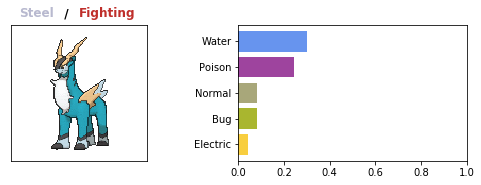

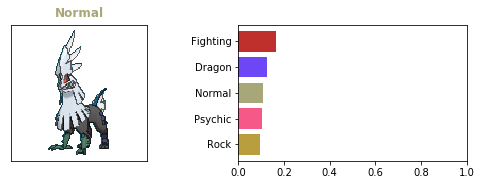

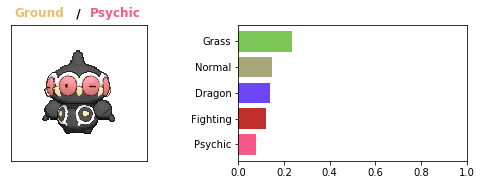

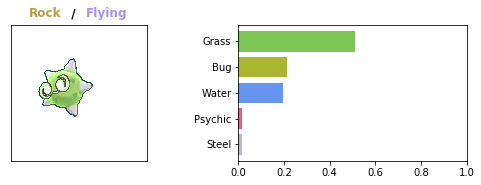

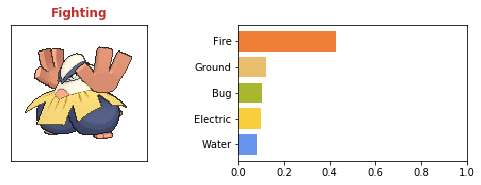

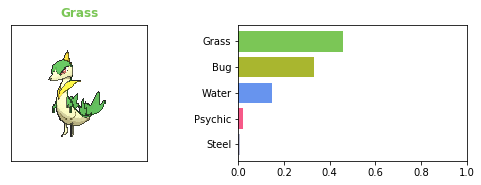

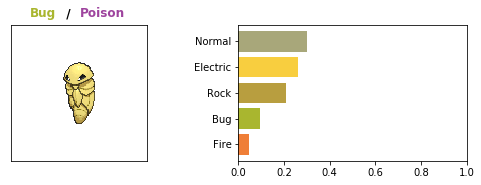

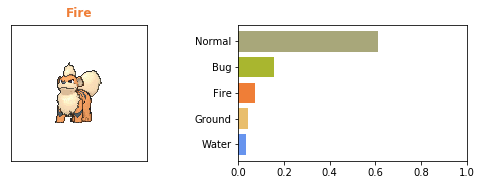

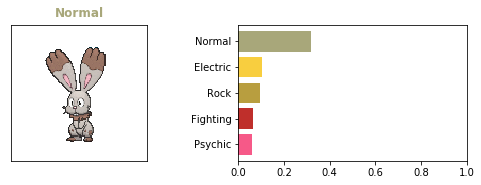

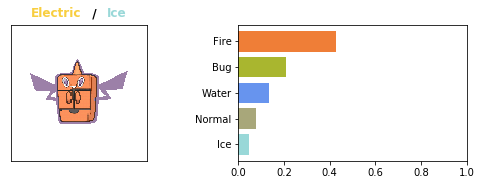

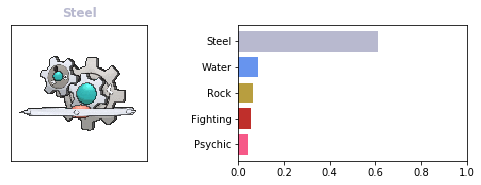

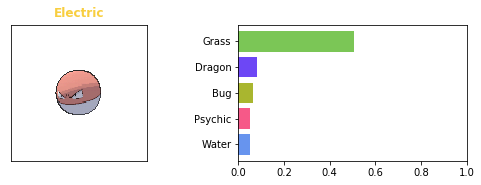

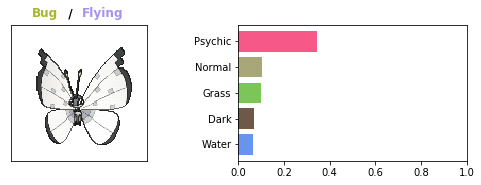

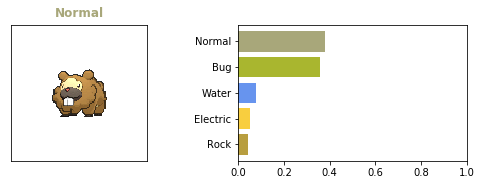

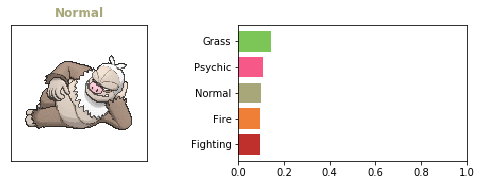

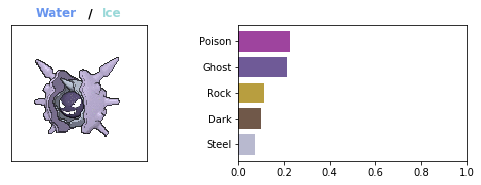

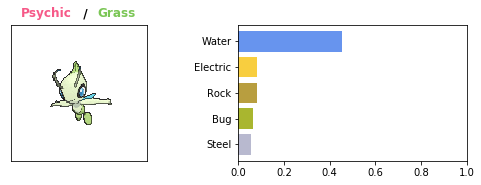

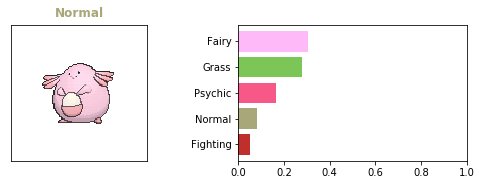

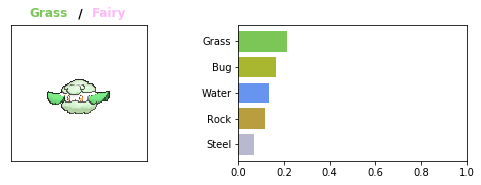

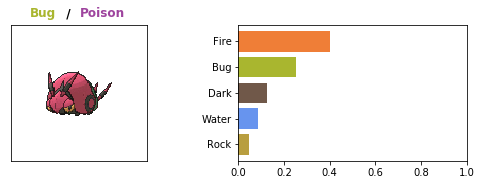

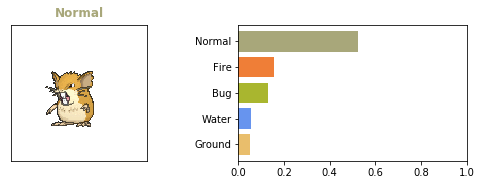

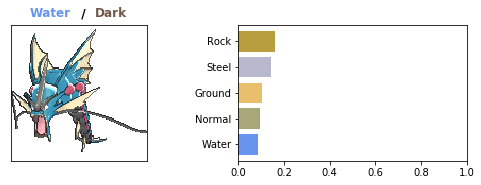

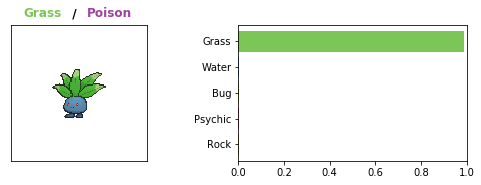

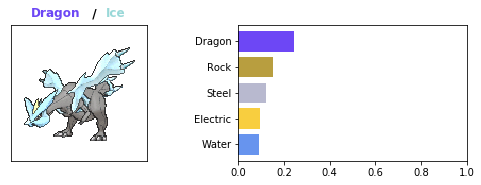

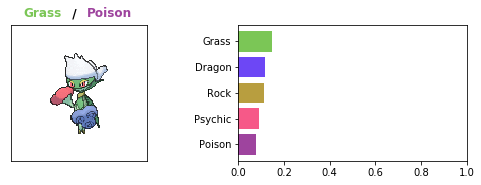

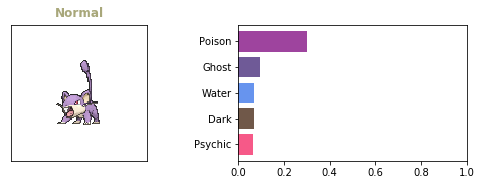

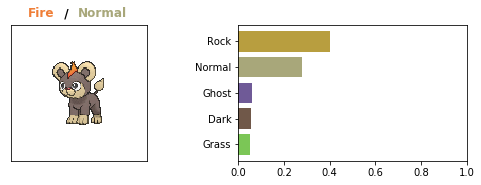

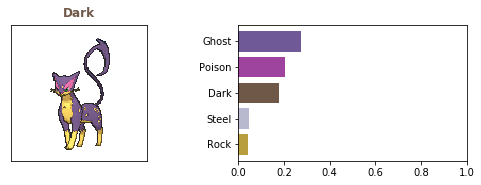

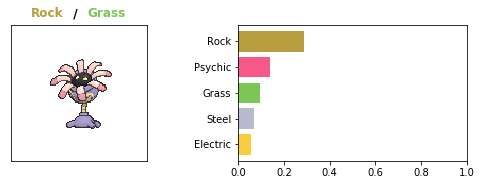

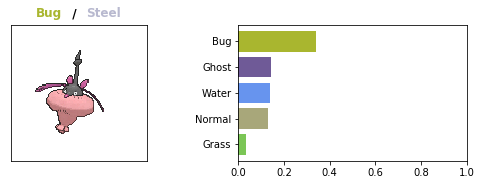

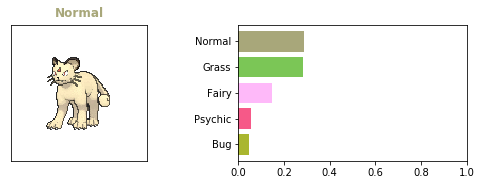

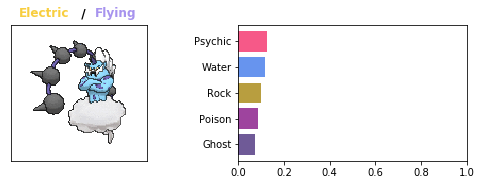

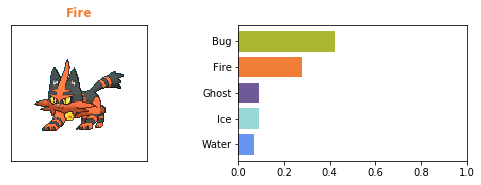

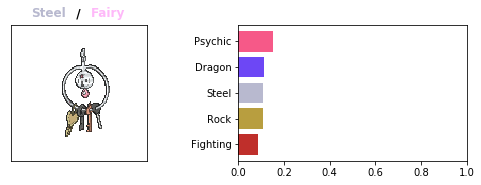

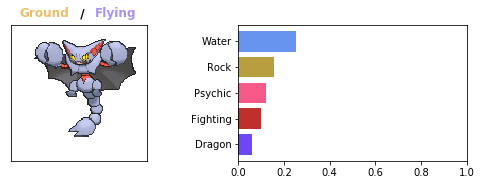

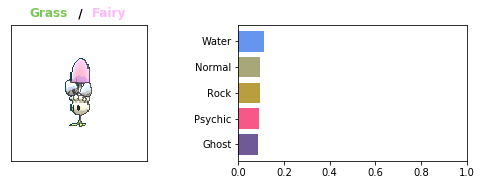

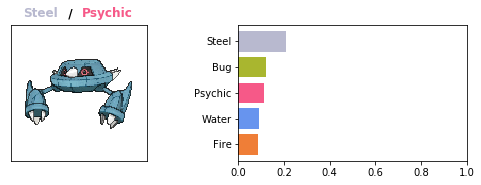

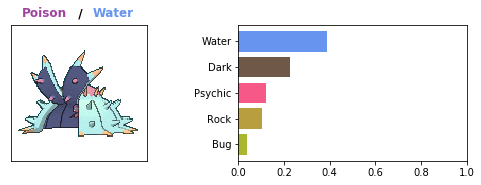

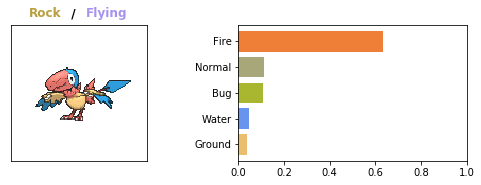

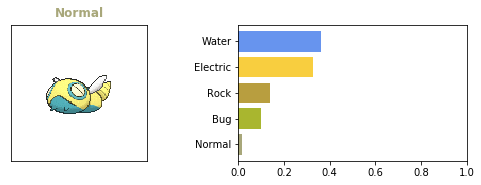

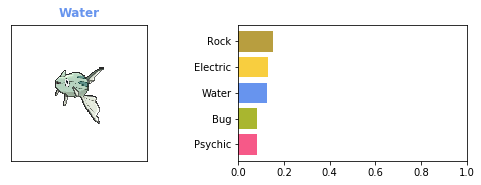

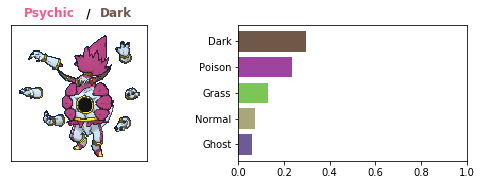

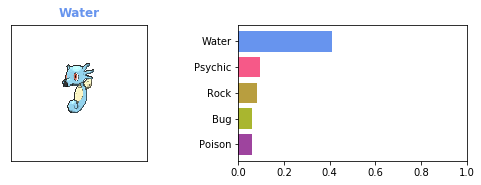

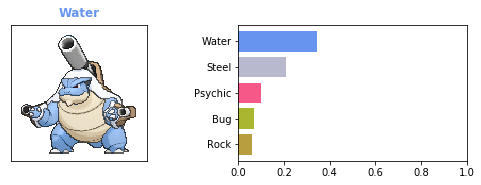

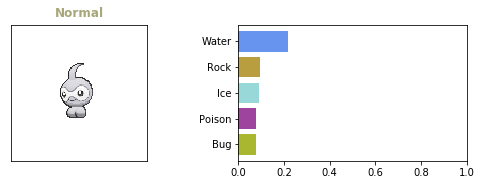

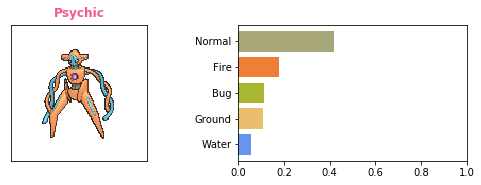

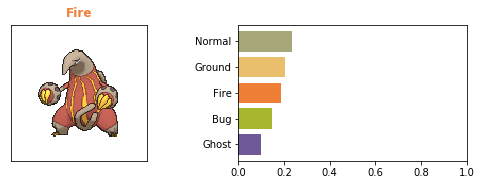

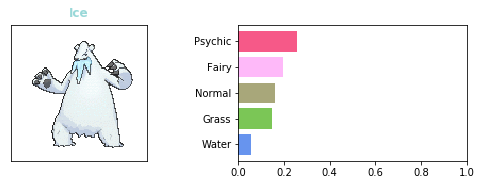

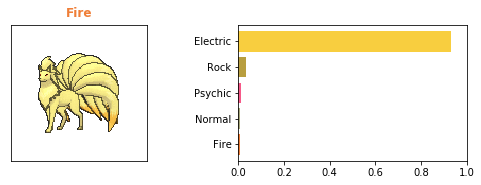

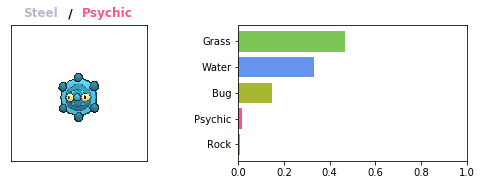

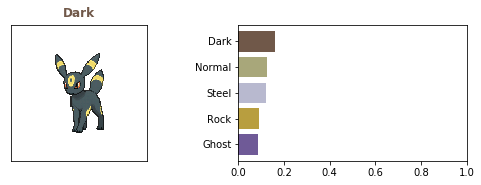

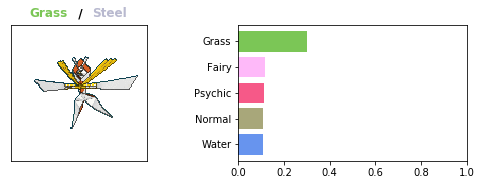

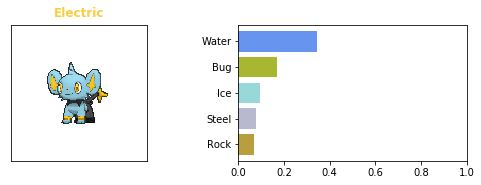

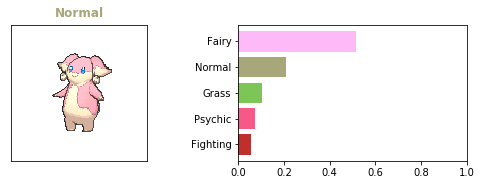

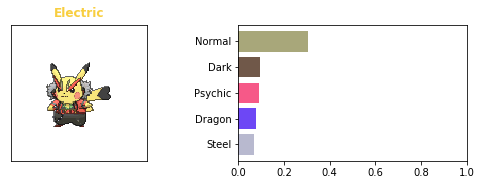

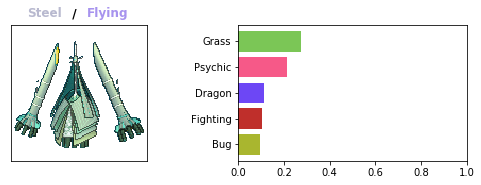

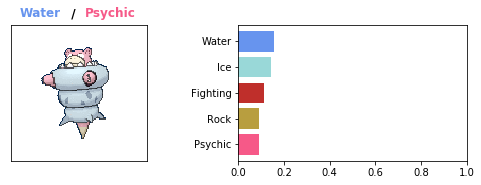

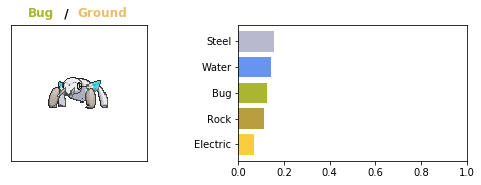

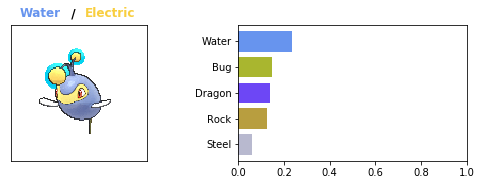

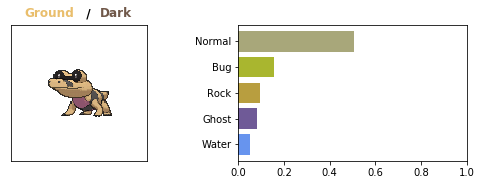

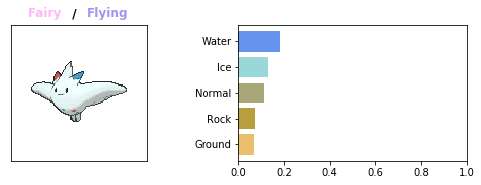

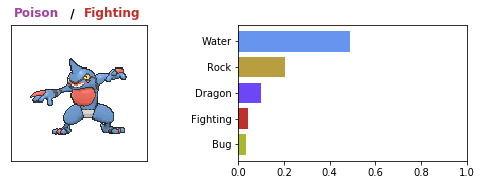

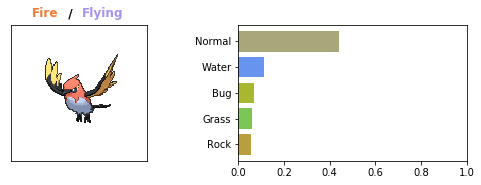

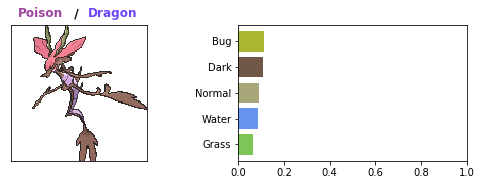

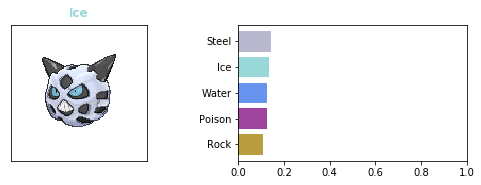

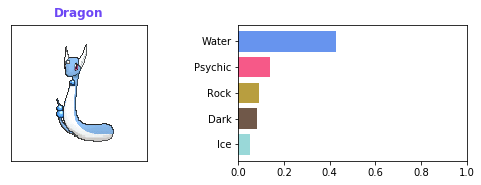

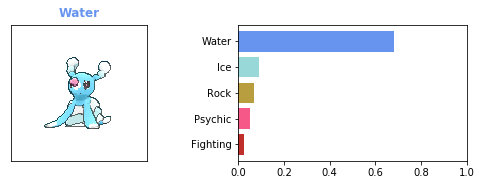

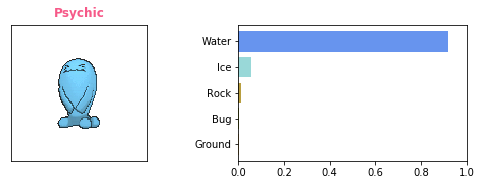

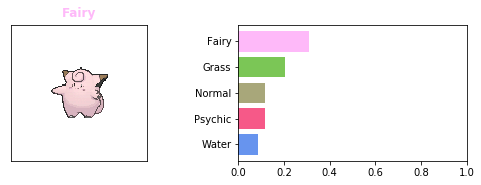

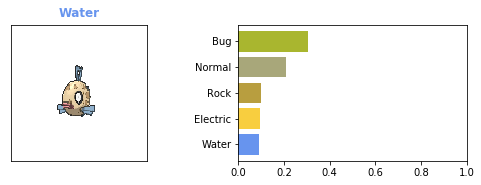

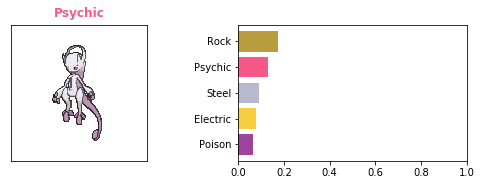

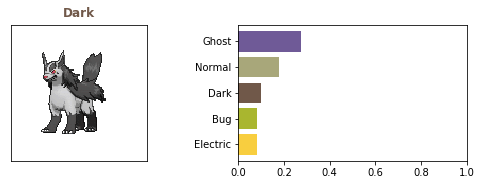

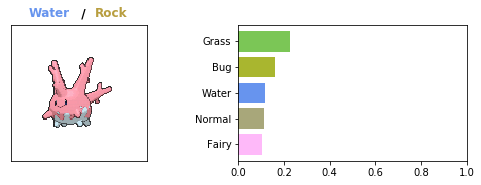

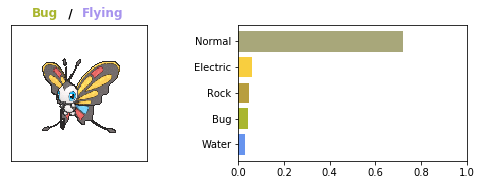

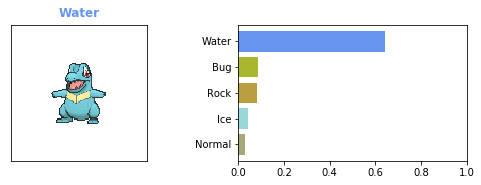

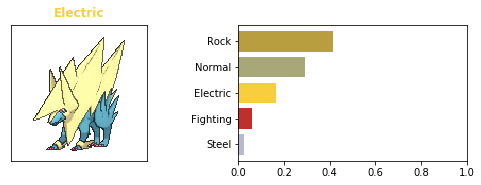

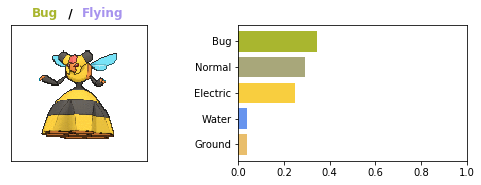

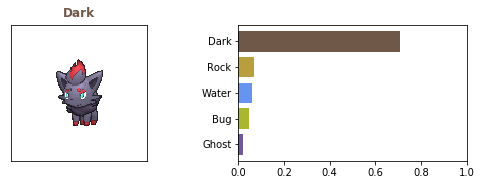

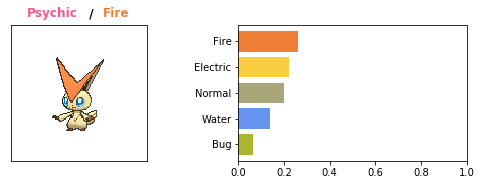

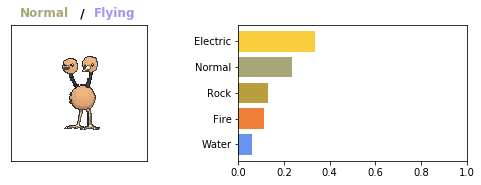

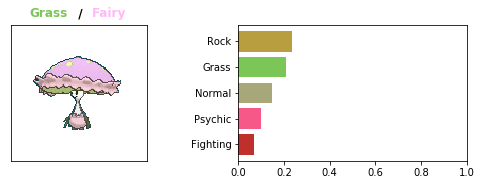

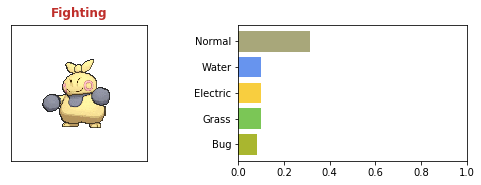

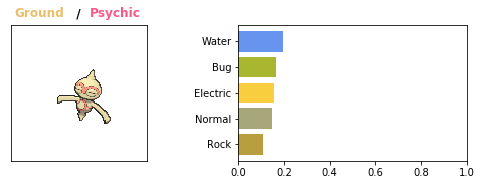

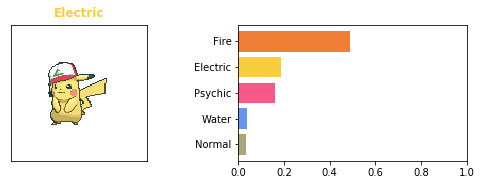

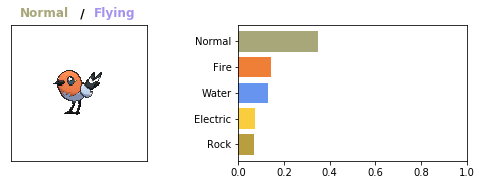

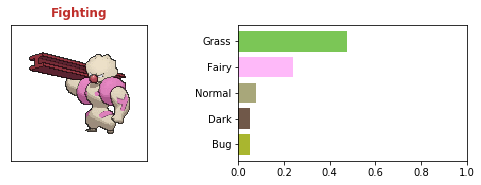

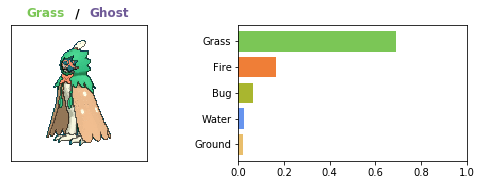

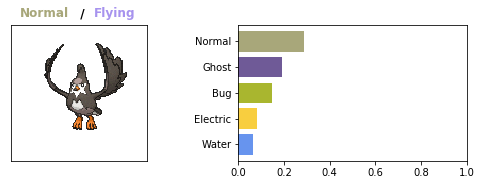

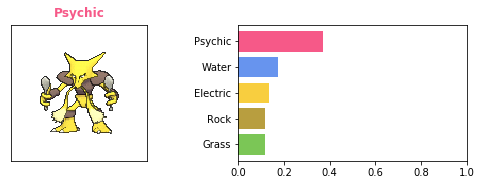

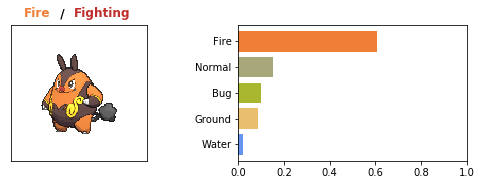

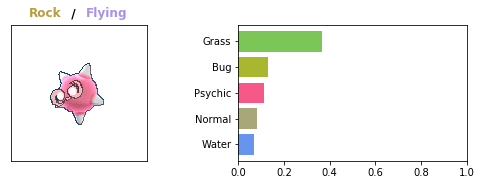

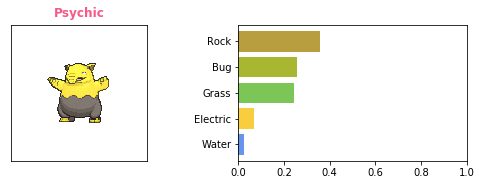

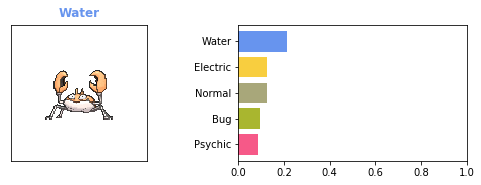

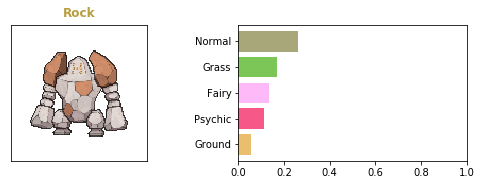

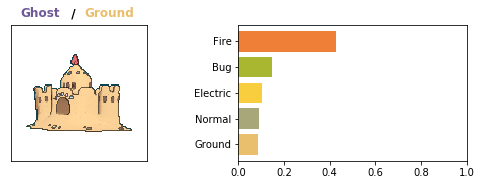

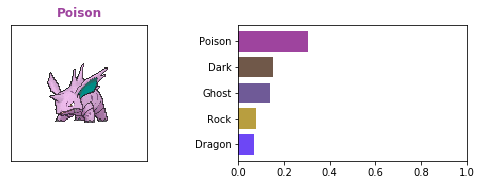

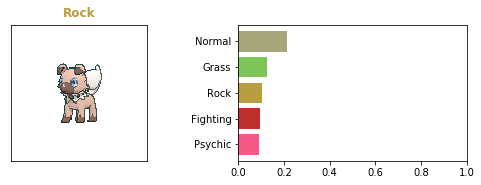

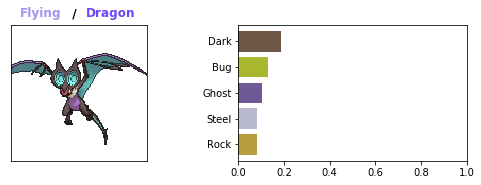

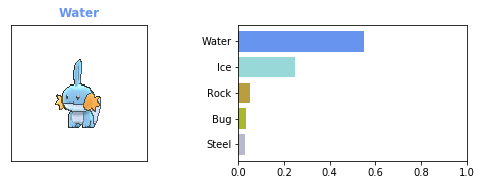

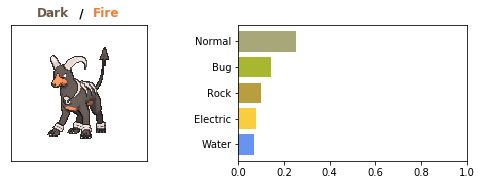

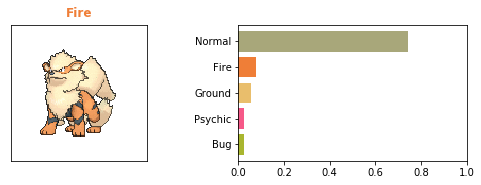

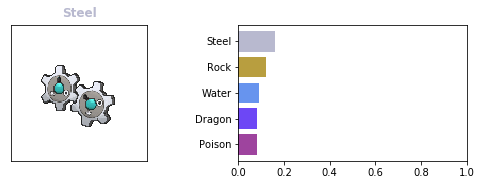

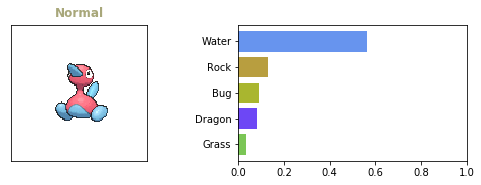

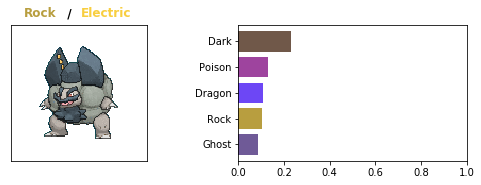

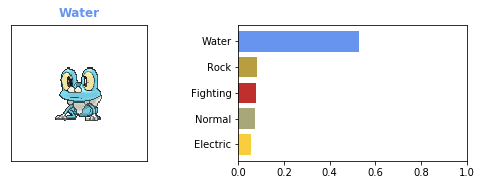

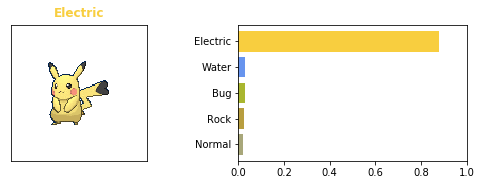

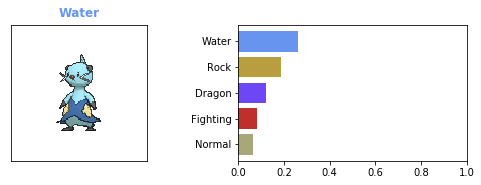

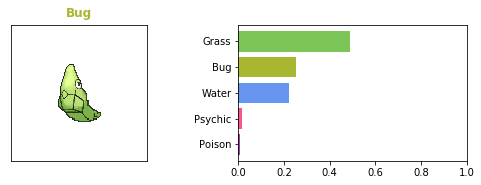

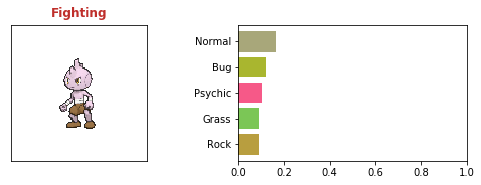

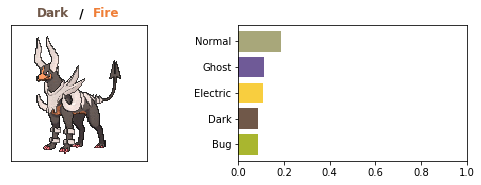

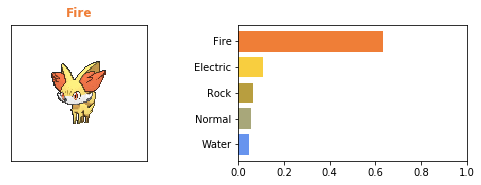

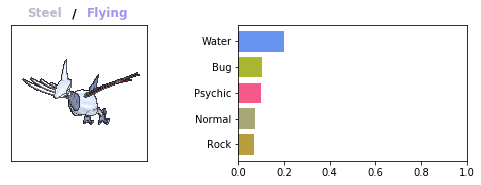

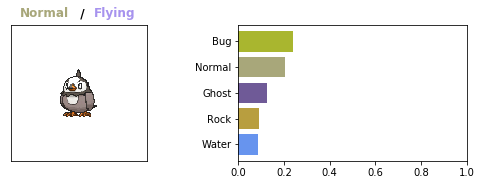

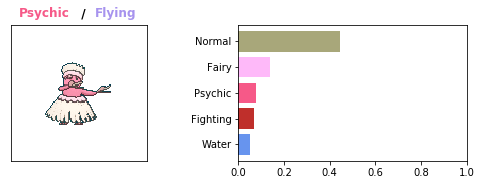

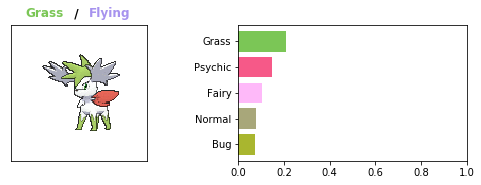

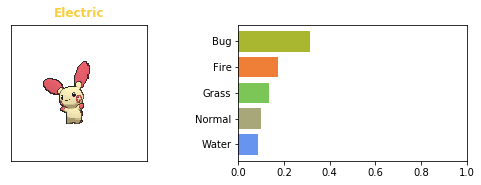

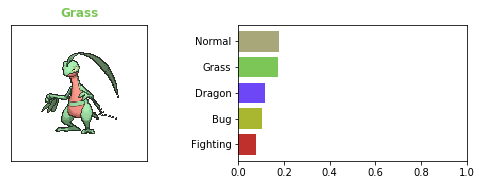

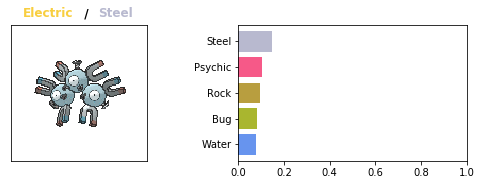

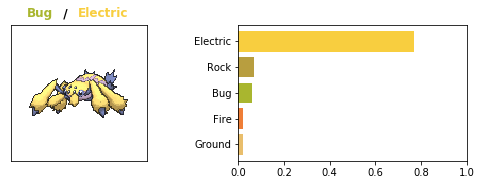

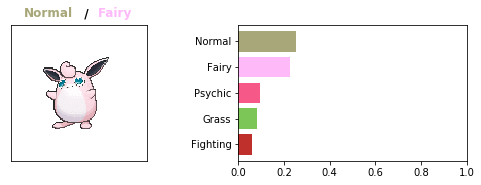

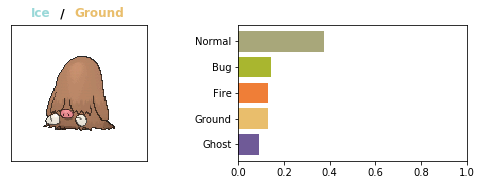

In [95]:
start = 0  # start index
num = 200    # number of images to display
step = 10  # number of frames / pokemon animation

print("Test predictions")
pp.plotPredictions(x_test_i[start*step:(start+num)*step:step],
                   y_test_m[start*step:(start+num)*step:step],
                   test_avg_scores[start:start+num:1], k=5, y2=y_test_2[start*step:(start+num)*step:step])

In [12]:
drops = []
regs = []
val_accs = []
train_accs = []

In [30]:
# Test levels of regularization
for i in range(100):
    print()
    print("> Iteration", i+1)
    r = np.random.uniform(-5,-1)
    d = np.random.uniform(np.log10(0.1),np.log10(0.99))
    reg = 10**r
    drop = 10**d
    model = getInitialModel(False, reg=reg, drop=drop)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    batch_size = 64
    aug_factor = 1
    history = model.fit_generator(
        data_aug.flow(x_train_s, oneHot(y_train_s, 18), batch_size=batch_size),
        epochs=5,
        verbose=1,
        validation_data=(x_val_s, oneHot(y_val_s, 18)),
        steps_per_epoch=x_train_s.shape[0] // batch_size * aug_factor
    )
    drops.append(drop)
    regs.append(reg)
    val_accs.append(history.history['val_acc'])
    train_accs.append(history.history['acc'])


> Iteration 1
Model params: drop = 0.12344805014903978 , reg = 0.0002420528325559459
Epoch 1/5
9/9 [==============================] - 17s 2s/step - loss: 2.9010 - acc: 0.1172 - val_loss: 2.8417 - val_acc: 0.1258
Epoch 2/5
9/9 [==============================] - 18s 2s/step - loss: 2.8255 - acc: 0.1476 - val_loss: 2.8447 - val_acc: 0.1391
Epoch 3/5
9/9 [==============================] - 16s 2s/step - loss: 2.7580 - acc: 0.1736 - val_loss: 2.8339 - val_acc: 0.1589
Epoch 4/5
9/9 [==============================] - 17s 2s/step - loss: 2.7946 - acc: 0.1553 - val_loss: 2.8155 - val_acc: 0.1722
Epoch 5/5
9/9 [==============================] - 17s 2s/step - loss: 2.6850 - acc: 0.2000 - val_loss: 2.9558 - val_acc: 0.1126

> Iteration 2
Model params: drop = 0.1931867234490158 , reg = 0.004068426941566699
Epoch 1/5
9/9 [==============================] - 19s 2s/step - loss: 3.5865 - acc: 0.1024 - val_loss: 3.3977 - val_acc: 0.1258
Epoch 2/5
9/9 [==============================] - 16s 2s/step - loss:

9/9 [==============================] - 17s 2s/step - loss: 2.8036 - acc: 0.1462 - val_loss: 2.8363 - val_acc: 0.0728
Epoch 3/5
9/9 [==============================] - 17s 2s/step - loss: 2.7363 - acc: 0.1360 - val_loss: 2.7885 - val_acc: 0.1258
Epoch 4/5
9/9 [==============================] - 17s 2s/step - loss: 2.7331 - acc: 0.1332 - val_loss: 2.7994 - val_acc: 0.1325
Epoch 5/5
9/9 [==============================] - 17s 2s/step - loss: 2.6801 - acc: 0.1545 - val_loss: 2.8437 - val_acc: 0.1060

> Iteration 13
Model params: drop = 0.1429885059504126 , reg = 0.0026340942463117588
Epoch 1/5
9/9 [==============================] - 20s 2s/step - loss: 3.4498 - acc: 0.0783 - val_loss: 3.2771 - val_acc: 0.0795
Epoch 2/5
9/9 [==============================] - 18s 2s/step - loss: 3.1961 - acc: 0.1094 - val_loss: 3.1980 - val_acc: 0.0795
Epoch 3/5
9/9 [==============================] - 17s 2s/step - loss: 3.0707 - acc: 0.1479 - val_loss: 3.1031 - val_acc: 0.1325
Epoch 4/5
9/9 [====================

Epoch 1/5
9/9 [==============================] - 20s 2s/step - loss: 6.3905 - acc: 0.1122 - val_loss: 5.0458 - val_acc: 0.1325
Epoch 2/5
9/9 [==============================] - 17s 2s/step - loss: 4.7788 - acc: 0.1451 - val_loss: 4.4285 - val_acc: 0.1258
Epoch 3/5
9/9 [==============================] - 17s 2s/step - loss: 4.2038 - acc: 0.1416 - val_loss: 3.9448 - val_acc: 0.1258
Epoch 4/5
9/9 [==============================] - 19s 2s/step - loss: 3.8377 - acc: 0.1337 - val_loss: 3.6982 - val_acc: 0.1325
Epoch 5/5
9/9 [==============================] - 16s 2s/step - loss: 3.5964 - acc: 0.1619 - val_loss: 3.5714 - val_acc: 0.1258

> Iteration 26
Model params: drop = 0.2779444902300954 , reg = 0.0015415672120515289
Epoch 1/5
9/9 [==============================] - 21s 2s/step - loss: 3.2038 - acc: 0.0776 - val_loss: 3.1545 - val_acc: 0.0795
Epoch 2/5
9/9 [==============================] - 17s 2s/step - loss: 3.0478 - acc: 0.0926 - val_loss: 3.0764 - val_acc: 0.0993
Epoch 3/5
9/9 [==========

9/9 [==============================] - 17s 2s/step - loss: 2.8932 - acc: 0.1004 - val_loss: 2.8836 - val_acc: 0.1258
Epoch 4/5
9/9 [==============================] - 17s 2s/step - loss: 2.8721 - acc: 0.1311 - val_loss: 2.8537 - val_acc: 0.0530
Epoch 5/5
9/9 [==============================] - 18s 2s/step - loss: 2.8825 - acc: 0.1146 - val_loss: 2.8797 - val_acc: 0.1258

> Iteration 38
Model params: drop = 0.1075605931642152 , reg = 0.001545131909958758
Epoch 1/5
9/9 [==============================] - 21s 2s/step - loss: 3.1238 - acc: 0.1213 - val_loss: 3.1169 - val_acc: 0.1258
Epoch 2/5
9/9 [==============================] - 19s 2s/step - loss: 3.0069 - acc: 0.1441 - val_loss: 3.0371 - val_acc: 0.1126
Epoch 3/5
9/9 [==============================] - 16s 2s/step - loss: 2.9479 - acc: 0.1789 - val_loss: 3.0015 - val_acc: 0.1457
Epoch 4/5
9/9 [==============================] - 17s 2s/step - loss: 2.9094 - acc: 0.1210 - val_loss: 2.9706 - val_acc: 0.1258
Epoch 5/5
9/9 [=====================

9/9 [==============================] - 18s 2s/step - loss: 2.8739 - acc: 0.1087 - val_loss: 2.8452 - val_acc: 0.1258

> Iteration 49
Model params: drop = 0.2529540013956891 , reg = 0.00010565293662152163
Epoch 1/5
9/9 [==============================] - 24s 3s/step - loss: 2.9971 - acc: 0.1337 - val_loss: 2.8969 - val_acc: 0.1325
Epoch 2/5
9/9 [==============================] - 16s 2s/step - loss: 2.8685 - acc: 0.1436 - val_loss: 2.8578 - val_acc: 0.1258
Epoch 3/5
9/9 [==============================] - 18s 2s/step - loss: 2.8426 - acc: 0.1542 - val_loss: 2.8533 - val_acc: 0.1325
Epoch 4/5
9/9 [==============================] - 17s 2s/step - loss: 2.7860 - acc: 0.1636 - val_loss: 2.8114 - val_acc: 0.1258
Epoch 5/5
9/9 [==============================] - 19s 2s/step - loss: 2.7696 - acc: 0.1493 - val_loss: 2.7869 - val_acc: 0.1457

> Iteration 50
Model params: drop = 0.23803445073192595 , reg = 0.0066644201961100725
Epoch 1/5
9/9 [==============================] - 23s 3s/step - loss: 4.004

Epoch 1/5
9/9 [==============================] - 24s 3s/step - loss: 3.1600 - acc: 0.0801 - val_loss: 3.1315 - val_acc: 0.1060
Epoch 2/5
9/9 [==============================] - 18s 2s/step - loss: 3.0988 - acc: 0.0941 - val_loss: 3.0734 - val_acc: 0.1060
Epoch 3/5
9/9 [==============================] - 19s 2s/step - loss: 3.0308 - acc: 0.1111 - val_loss: 3.0399 - val_acc: 0.1192
Epoch 4/5
9/9 [==============================] - 16s 2s/step - loss: 2.9636 - acc: 0.1398 - val_loss: 2.9939 - val_acc: 0.1258
Epoch 5/5
9/9 [==============================] - 17s 2s/step - loss: 2.9015 - acc: 0.1542 - val_loss: 2.9852 - val_acc: 0.0927

> Iteration 63
Model params: drop = 0.10358137570180531 , reg = 0.06356870944473411
Epoch 1/5
9/9 [==============================] - 23s 3s/step - loss: 10.6422 - acc: 0.0986 - val_loss: 7.3197 - val_acc: 0.1126
Epoch 2/5
9/9 [==============================] - 19s 2s/step - loss: 6.7629 - acc: 0.1094 - val_loss: 6.2067 - val_acc: 0.1258
Epoch 3/5
9/9 [==========

9/9 [==============================] - 17s 2s/step - loss: 3.1568 - acc: 0.1545 - val_loss: 3.1671 - val_acc: 0.1258
Epoch 4/5
9/9 [==============================] - 17s 2s/step - loss: 3.0228 - acc: 0.1490 - val_loss: 3.0990 - val_acc: 0.1258
Epoch 5/5
9/9 [==============================] - 17s 2s/step - loss: 3.0261 - acc: 0.1552 - val_loss: 3.0555 - val_acc: 0.1126

> Iteration 74
Model params: drop = 0.7379153720903848 , reg = 0.01626749820627339
Epoch 1/5
9/9 [==============================] - 23s 3s/step - loss: 5.4272 - acc: 0.0818 - val_loss: 4.6820 - val_acc: 0.0728
Epoch 2/5
9/9 [==============================] - 18s 2s/step - loss: 4.5108 - acc: 0.1007 - val_loss: 4.2888 - val_acc: 0.1258
Epoch 3/5
9/9 [==============================] - 17s 2s/step - loss: 4.1269 - acc: 0.0982 - val_loss: 3.9635 - val_acc: 0.1258
Epoch 4/5
9/9 [==============================] - 17s 2s/step - loss: 3.8500 - acc: 0.1046 - val_loss: 3.7308 - val_acc: 0.1258
Epoch 5/5
9/9 [======================

9/9 [==============================] - 17s 2s/step - loss: 3.0282 - acc: 0.1860 - val_loss: 3.1078 - val_acc: 0.1391
Epoch 5/5
9/9 [==============================] - 17s 2s/step - loss: 2.9737 - acc: 0.1832 - val_loss: 2.9949 - val_acc: 0.1788

> Iteration 86
Model params: drop = 0.2904949915264605 , reg = 0.0227926808694837
Epoch 1/5
9/9 [==============================] - 25s 3s/step - loss: 6.2215 - acc: 0.0976 - val_loss: 5.1321 - val_acc: 0.0927
Epoch 2/5
9/9 [==============================] - 17s 2s/step - loss: 4.8464 - acc: 0.1210 - val_loss: 4.5650 - val_acc: 0.1126
Epoch 3/5
9/9 [==============================] - 17s 2s/step - loss: 4.3240 - acc: 0.1080 - val_loss: 4.1193 - val_acc: 0.1258
Epoch 4/5
9/9 [==============================] - 17s 2s/step - loss: 3.9460 - acc: 0.1210 - val_loss: 3.8694 - val_acc: 0.1258
Epoch 5/5
9/9 [==============================] - 18s 2s/step - loss: 3.7481 - acc: 0.1389 - val_loss: 3.6996 - val_acc: 0.1060

> Iteration 87
Model params: drop = 0

Epoch 1/5
9/9 [==============================] - 25s 3s/step - loss: 2.8340 - acc: 0.1062 - val_loss: 2.8353 - val_acc: 0.0927
Epoch 2/5
9/9 [==============================] - 18s 2s/step - loss: 2.7244 - acc: 0.1632 - val_loss: 2.7775 - val_acc: 0.1722
Epoch 3/5
9/9 [==============================] - 16s 2s/step - loss: 2.6554 - acc: 0.1709 - val_loss: 2.7523 - val_acc: 0.1656
Epoch 4/5
9/9 [==============================] - 18s 2s/step - loss: 2.6153 - acc: 0.1875 - val_loss: 2.7655 - val_acc: 0.1523
Epoch 5/5
9/9 [==============================] - 17s 2s/step - loss: 2.5930 - acc: 0.1906 - val_loss: 2.7043 - val_acc: 0.2053

> Iteration 98
Model params: drop = 0.483753318377557 , reg = 0.0550311014983851
Epoch 1/5
9/9 [==============================] - 26s 3s/step - loss: 9.9664 - acc: 0.0836 - val_loss: 7.1417 - val_acc: 0.1258
Epoch 2/5
9/9 [==============================] - 17s 2s/step - loss: 6.6694 - acc: 0.1224 - val_loss: 6.0840 - val_acc: 0.1192
Epoch 3/5
9/9 [==============

/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:853: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


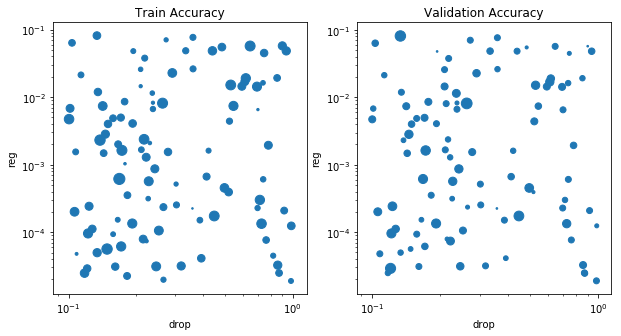

In [47]:
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(1,2)

for i in range(2):
    t = None
    accs = None
    if i == 0:
        t = "Train"
        accs = train_accs
    else:
        t = "Validation"
        accs = val_accs
        
    ax = plt.subplot(gs[i])
    ax.set_title(t + " Accuracy")
    ax.set_xlabel("drop")
    ax.set_xscale('log')
    ax.set_ylabel("reg")
    ax.set_yscale('log')
    
    # MAKE SURE GETTING LAST ACCURACY
    ax.scatter(np.array(drops), np.array(regs), s=(np.array(accs)[:,4]-0.09)*1e3)
plt.show()

In [39]:
val_accs2 = val_accs
train_accs2 = train_accs

In [40]:
train_accs = [a for a in train_accs2 if len(a)>2]
val_accs = [a for a in val_accs2 if len(a)>2]
print(len(train_accs))
print(len(val_accs))

100
100


In [102]:
print(10**-.6, 10**(-2.1))

0.251188643150958 0.007943282347242814
